In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def reset_params():
    params = {}
    params['a'] = 270 #Hz/nA
    params['b'] = 108 #Hz
    params['d'] = 0.154 #s
    params['gamma'] = 0.641
    params['tau_s'] = 100/1000 #s (100 ms)
    params['gE'] = 0.2609 #nA
    params['gI'] = 0.0497 #nA
    params['gext'] = 0.00052 #nA
    params['I0'] = 0.3255 #nA
    params['tau_0'] = 2/1000 #s (2 ms)
    params['sig'] = 0.02 #nA
    params['Tmax'] = 3 #s
    params['del_t'] = 0.001 #s (1 ms)
    params['ntrials'] = 10
    params['len_T'] = int(params['Tmax']/params['del_t'])
    return params
params = reset_params()

fdict = {}
fdict['stitle'] = 20
fdict['title'] = 16
fdict['axes'] = 14

In [3]:
def firing_rate(I_val, params):
    a = params['a']
    b = params['b']
    d = params['d']
    r = (a*I_val-b)/(1-np.exp(-d*(a*I_val-b)))
    return r

def background_input():
    tau_0 = params['tau_0']
    I0 = params['I0']
    sig = params['sig']
    del_t = params['del_t']
    len_T = params['len_T']
    Ib = np.zeros((2, len_T))
    for t in range(len_T-1):
        for ii in range(2):
            Ib[ii, t+1] = Ib[ii, t] + ((del_t/tau_0) * (-(Ib[ii, t] - I0) )) + (np.sqrt(del_t/tau_0)*sig*np.random.normal())
    return Ib

def synaptic_dynamics(mu, params):
    gamma = params['gamma']
    tau_s = params['tau_s']
    d = params['d']
    gE = params['gE']
    gI = params['gI']
    gext = params['gext']
    del_t = params['del_t']
    ntrials = params['ntrials']
    len_T = params['len_T']
    s = 0.1 * np.ones((2,len_T, ntrials))
    r = np.zeros((2,len_T, ntrials))
    for ff in range(ntrials):
        
        Ib = background_input()
        for t in range(len_T - 1):
            I = np.zeros(2,)
            I[0] = gE * s[0, t, ff] - gI * s[1, t, ff] + Ib[0, t] + gext * mu[0, t]
            I[1] = gE * s[1, t, ff] - gI * s[0, t, ff] + Ib[1, t] + gext * mu[1, t]
            # if gE_stable == 'no':
            #     if t >= decay_start:
            #         gE -= 0.01
            for ii in range(len(I)):
                r[ii, t, ff] = firing_rate(I[ii], params)
                del_s = (r[ii, t, ff] * gamma * (1-s[ii, t, ff])) - (s[ii, t, ff]/tau_s)
                s[ii, t+1, ff] = s[ii, t, ff] + del_t * del_s
    return s,r

def plot_fr_dynamics(r, s, stim, t_stim, qnum, params, fdict):
    contrasts = [0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1]

    if qnum == '1a':
        tname = 'Resting state'
    elif qnum == '1b1':
        tname = 'Stimulus 1 on'
    elif qnum == '1b2':
        tname = 'Stimulus 2 on'
    elif qnum == '1b3':
        tname = 'Back to resting state'
    elif qnum == '1d':
        tname = 'Effect of distractor'
    elif qnum == '1e':
        tname = f'gE = {round(params["gE"], 3)}'
    elif qnum == '2':
        tname = 'Coin-tossing simulation for 10 trials'
    elif qnum[0] == '3':
        c_num = int(qnum[1])
        tname = f'Coherence = {contrasts[c_num]}'
    Tmax = params['Tmax']
    del_t = params['del_t']
    time = np.arange(0, Tmax, del_t)
    ticker_range = np.arange(0, Tmax+0.1, 0.5)
    t_stim = np.asarray(t_stim)

    fig, axs = plt.subplots(1, 3, figsize = (20, 6))
    axs[0].plot(time, stim[0, :], 'k')
    axs[0].plot(time, stim[1, :], 'r')
    axs[0].set_xlabel('Time (s)', fontsize = fdict['axes'])
    axs[0].set_ylabel('Stimulus', fontsize = fdict['axes'])
    axs[0].set_xticks(ticker_range)
    axs[0].set_title('Input current', fontsize = fdict['title'])

    axs[1].plot(time[:-1], s[0, :-1, :], 'k')
    axs[1].plot(time[:-1], s[1, :-1, :], 'r')
    for mm in range(t_stim.shape[0]):
        axs[1].axvline(x = t_stim[mm, 0]*del_t, color='m', linestyle = '--')
        axs[1].axvline(x = t_stim[mm, 1]*del_t, color='m', linestyle = '--')
    axs[1].set_xlabel('Time (s)', fontsize = fdict['axes'])
    axs[1].set_ylabel('Synaptic drive', fontsize = fdict['axes'])
    axs[1].set_xticks(ticker_range)
    axs[1].set_ylim([0, 1])
    axs[1].set_title('s(t)', fontsize = fdict['title'])

    axs[2].plot(time[:-1], r[0, :-1, :], 'k')
    axs[2].plot(time[:-1], r[1, :-1, :], 'r')
    for mm in range(t_stim.shape[0]):
        axs[2].axvline(x = t_stim[mm, 0]*del_t, color='m', linestyle = '--')
        axs[2].axvline(x = t_stim[mm, 1]*del_t, color='m', linestyle = '--')
    axs[2].set_xlabel('Time (s)', fontsize = fdict['axes'])
    axs[2].set_ylabel('Firing rate (Hz)', fontsize = fdict['axes'])
    axs[2].set_xticks(ticker_range)
    axs[2].set_title('r(t)', fontsize = fdict['title'])
    plt.suptitle(tname, fontsize = fdict['stitle'])
    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 6))
    p1 = axs[0].scatter(s[0, :-1, 0], s[1, :-1, 0], s = 5, c = time[:-1], cmap = 'plasma')
    axs[0].set_xlabel('S1', fontsize = fdict['axes'])
    axs[0].set_ylabel('S2', fontsize = fdict['axes'])
    axs[0].set_xlim([0, 1])
    axs[0].set_ylim([0, 1])
    axs[0].set_title('State space s(t)', fontsize = fdict['title'])

    max_r = np.ceil(np.max(r))
    p2 = axs[1].scatter(r[0, :-1, 0], r[1, :-1, 0], s = 5, c = time[:-1], cmap = 'plasma')
    axs[1].set_xlabel('Firing rate 1 (Hz)', fontsize = fdict['axes'])
    axs[1].set_ylabel('Firing rate 2 (Hz)', fontsize = fdict['axes'])
    axs[1].set_xlim([0, max_r])
    axs[1].set_ylim([0, max_r])
    axs[1].set_title('State space r(t)', fontsize = fdict['title'])
    cbar = fig.colorbar(p2)
    plt.show()

#### Q1. Consider first a delayed response task.
#### (a). First, run the model simulation for 500-1000 msec without stimulus ($\mu_1 = \mu_2 = 0 $). With the initial condition $s_1 = s_2 = 0 $, show that the system is at a resting state, and determine the firing rate at that state.
#### (b). After the system has settled in the resting state, show a stimulus ($\mu_1 = 35, \mu_2 = 0 $) for a brief period of time (say 300 msec), followed by a delay 'memory period' (say for 3 sec). Do you see a 'persistent activity' state, if so with what $r_1 $ and $r_2 $ values in Hz? Repeat the simulation with $\mu_1 = 0, \mu_2 = 35 $, do you observe another memory state and what are the corresponding $r_1 $ and $r_2 $ in Hz?
#### Find a way (using a second transient input at the end of the delay period) to switch the system from a memory state back to the resting state.
#### (c). Display time courses of $s_1 (t) $ and $s_2 (t) $, as well as firing rates $r_1 (t) = F(I_1) $ and $r_2 (t) = F(I_2)$. Also, plot $s_1 $ against $s_2 $, or $r_1 $ against $r_2 $ that traces a trajectory (each point corresponds to a moment in time) in the two-dimensional 'state space'. Describe what you observe.
#### (d). Repeat (b) but now show stimulus 1 as a cue ($\mu_1 = 35, \mu_2 = 0 $) briefly first, and during the delay show stimulus 2 as a distractor ($\mu_1 = 0, \mu_2 = 35 $), what do you see?
#### (e). Decrease the value of $g_E $ incrementally (by steps of 0.01 nA), and show that persistent activity disappears when the recurrent excitation is below a critical value. What is this critical level of recurrent excitation?

##### Resting state dynamics is modeled here for 3 seconds with no stimulus being presented throughout, and we can see that the system remains in the baseline firing state throughout. Looking at the state-space diagrams, we can see that the synaptic drive remains concentrated at lower values for both $s_1 $ and $s_2 $, whereas he firing rate is almost equal for both the populations and is concentrated at lower firing rates.

Mean resting state firing rate for population 1 is 2.1 Hz
Mean resting state firing rate for population 2 is 2.16 Hz


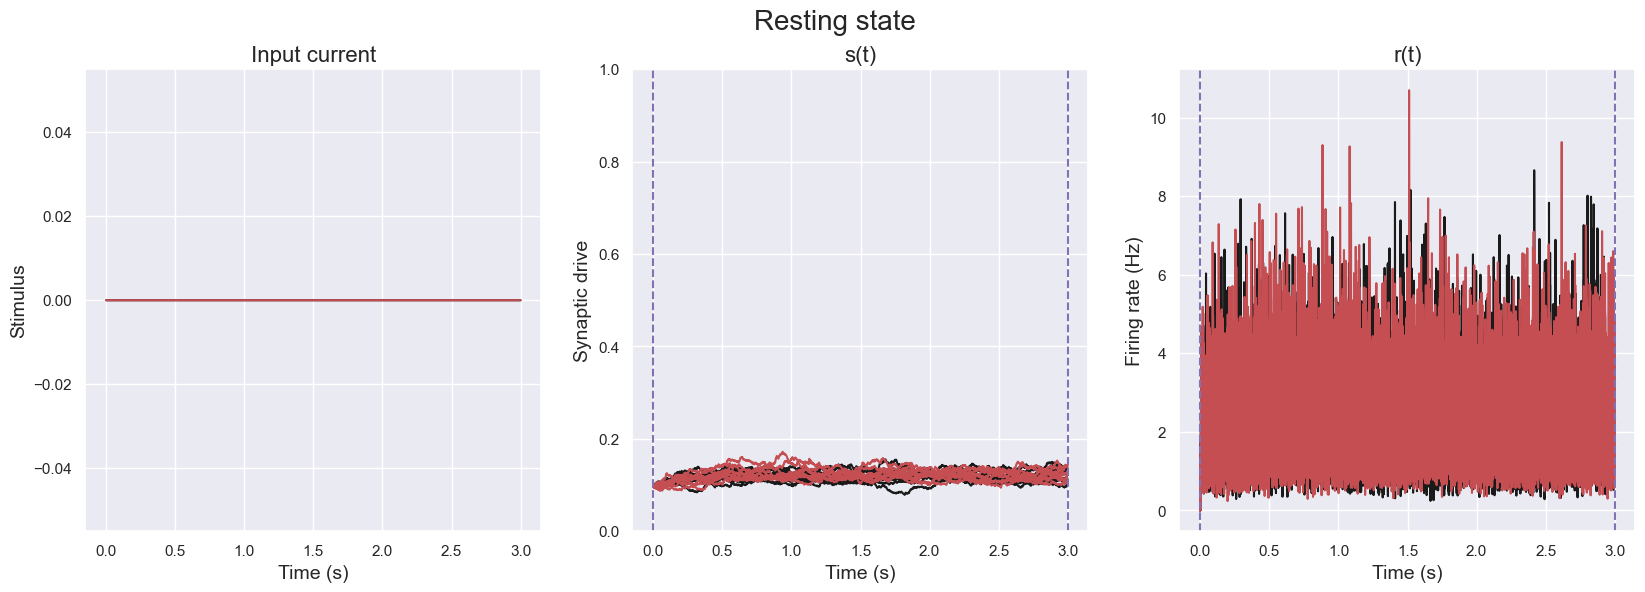

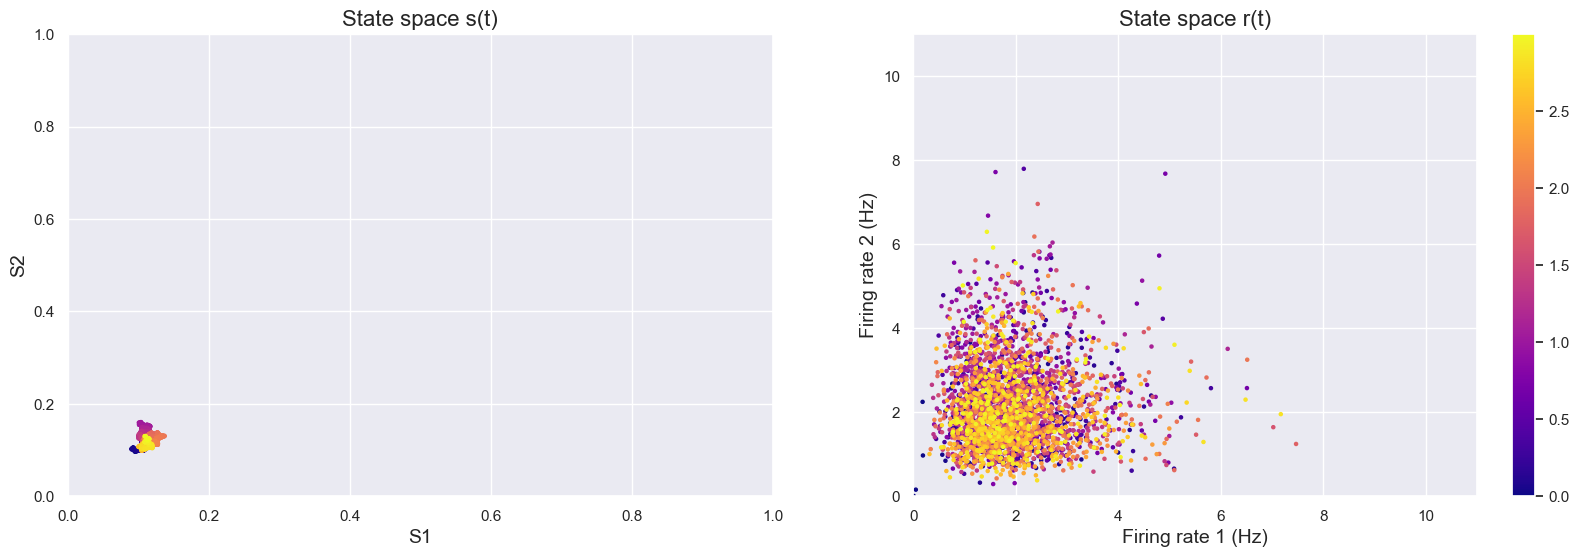

In [4]:
mu = np.zeros((2, params['len_T']))
t_stim = [[0, params['len_T']]]
s,r = synaptic_dynamics(mu, params)
print(f'Mean resting state firing rate for population 1 is {round(np.mean(r[0,:, :]), 2)} Hz')
print(f'Mean resting state firing rate for population 2 is {round(np.mean(r[1,:, :]), 2)} Hz')

plot_fr_dynamics(r, s, mu, t_stim, '1a', params, fdict)

##### When stimulus 1 is turned on for a short time, here from 500 - 800 ms, but the stimulus 2 is kept off, we can see that the synaptic drive for population 1 increases and remains high during the delay period where as the synaptic drive for population 2 decreases and remains low during the delay period. We can see the effect of this in the firing rate, whereas the firing rate of population 1 increases and remains high during the delay period, whereas for population 2, the firing rate remains low around baseline. Looking at the state space, we can see that the synaptic drive increases for population 1 while it decreases for population 2. And in the firing rate space, we can see that the firing rate increases for population 1 whereas it remains low for population 2.

Mean resting state firing rate for population 1 is 18.85 Hz
Mean resting state firing rate for population 2 is 0.68 Hz


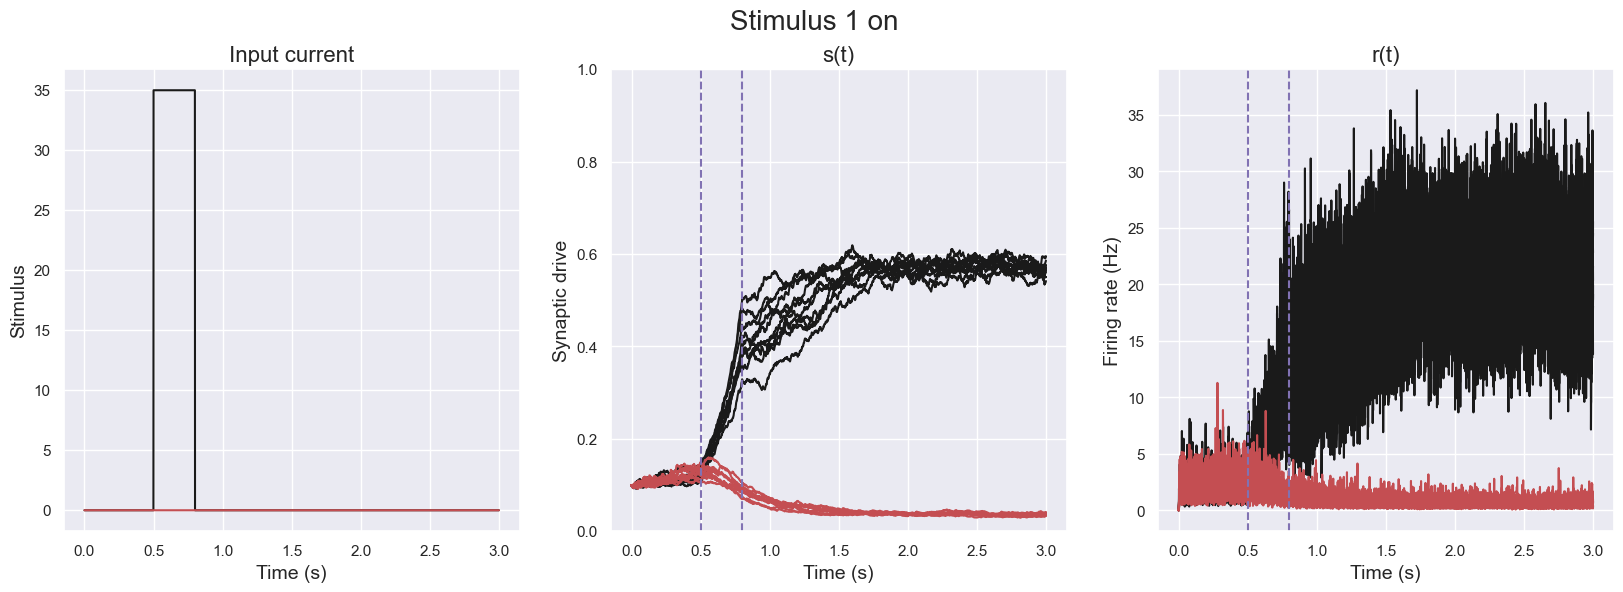

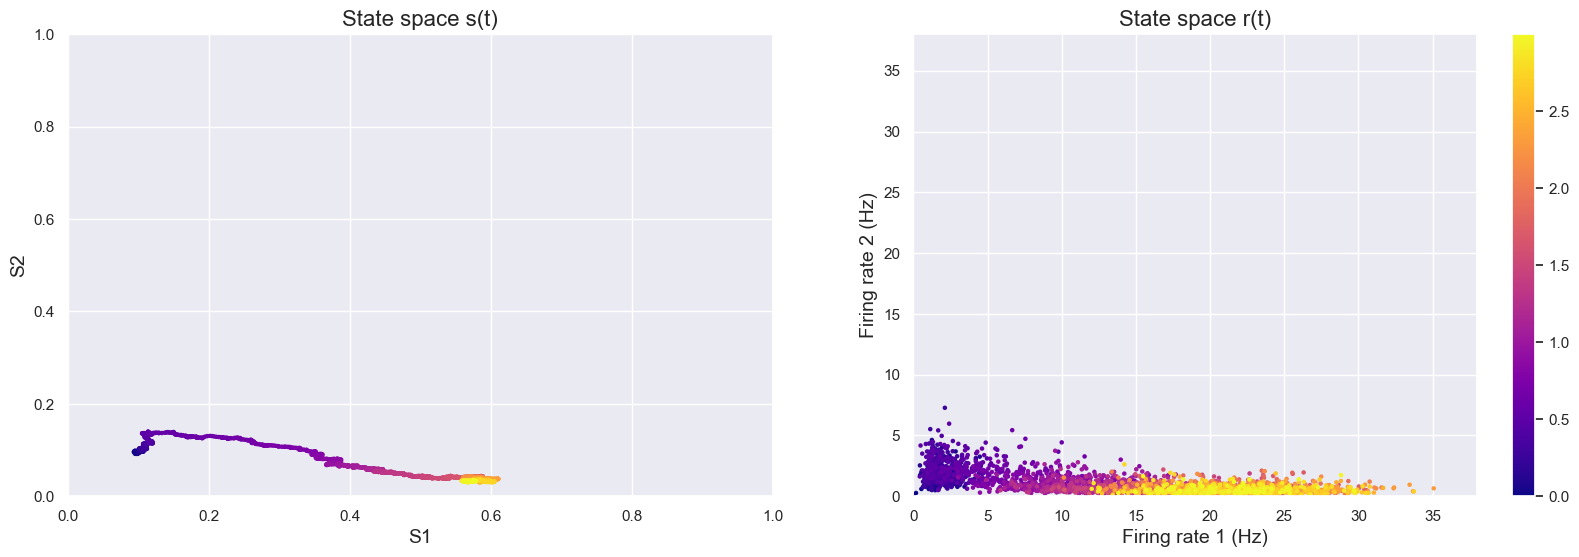

In [5]:
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 800]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 35
s,r = synaptic_dynamics(mu, params)
print(f'Mean resting state firing rate for population 1 is {round(np.mean(r[0,t_stim[0][1]:, :]), 2)} Hz')
print(f'Mean resting state firing rate for population 2 is {round(np.mean(r[1,t_stim[0][1]:, :]), 2)} Hz')

plot_fr_dynamics(r, s, mu, t_stim, '1b1', params, fdict)

##### Repeating the above procedure but now with Stimulus 2 being on while keeping Stimulus 1 is off, we can see that the synaptic drive for population 2 increases and remains high during the delay period where as the synaptic drive for population 1 decreases and remains low during the delay period. We can see the effect of this in the firing rate, whereas the firing rate of population 2 increases and remains high during the delay period, whereas for population 1, the firing rate remains low around baseline. Looking at the state space, we can see that the synaptic drive increases for population 2 while it decreases for population 1. And in the firing rate space, we can see that the firing rate increases for population 2 whereas it remains low for population 1.

Mean resting state firing rate for population 1 is 0.69 Hz
Mean resting state firing rate for population 2 is 18.25 Hz


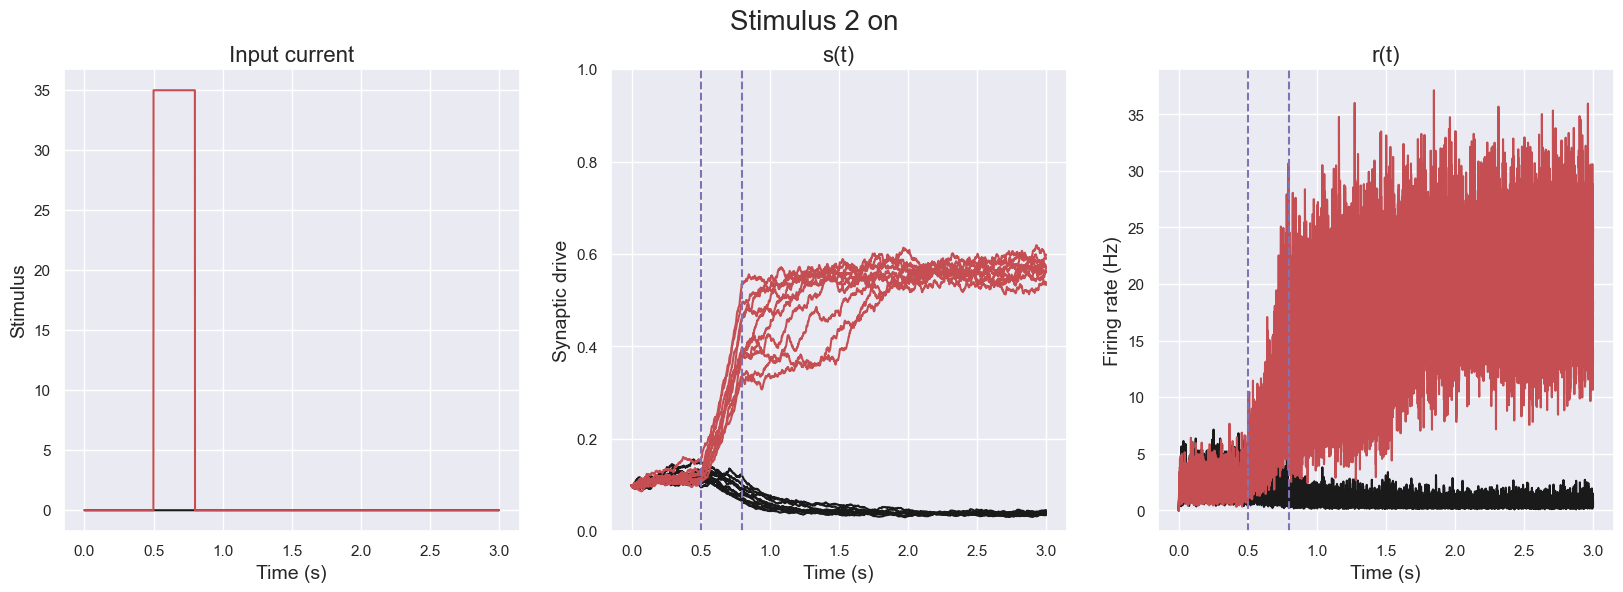

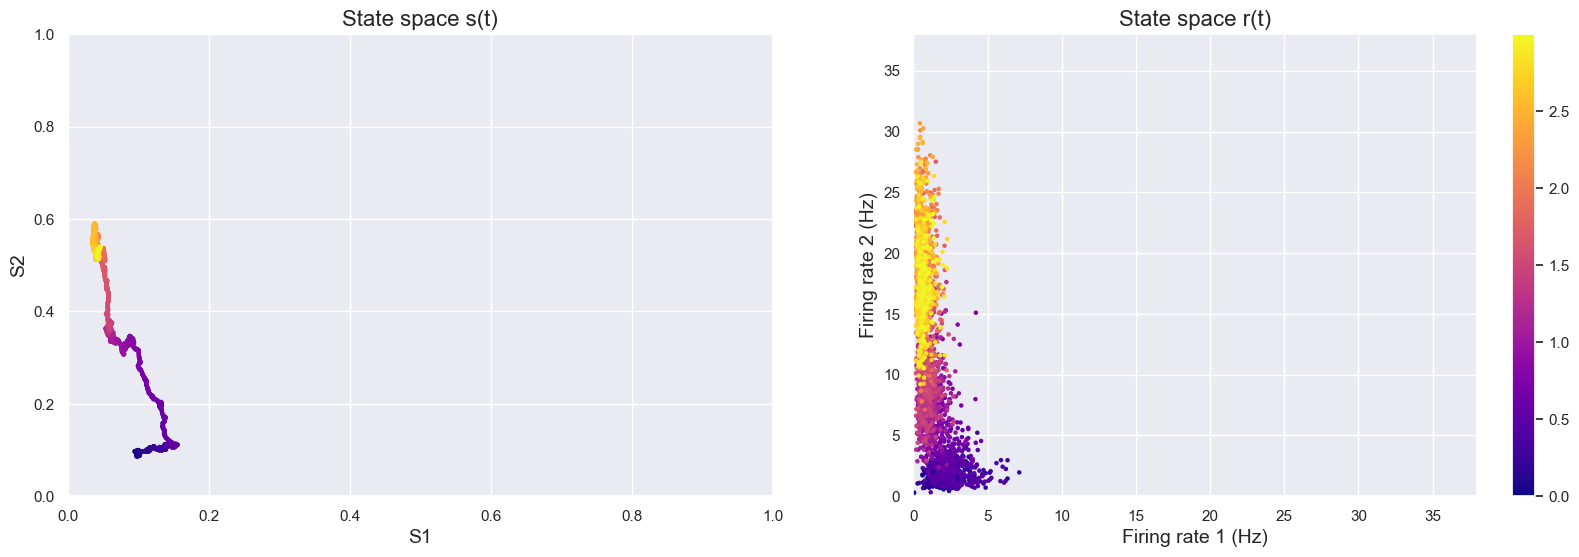

In [6]:
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 800]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[1, tt] = 35
s,r = synaptic_dynamics(mu, params)
print(f'Mean resting state firing rate for population 1 is {round(np.mean(r[0,t_stim[0][1]:, :]), 2)} Hz')
print(f'Mean resting state firing rate for population 2 is {round(np.mean(r[1,t_stim[0][1]:, :]), 2)} Hz')

plot_fr_dynamics(r, s, mu, t_stim, '1b2', params, fdict)

##### In order to turn off the persistent activity after the delay period in the given model, we can present the second stimulus at a higher intensity that brings the activity of the populations back to the baseline. In this case, Stimulus 1 is presented from 500 - 800 ms while keeping Stimulus 2 off and we can see that the synaptic drive for population 1 increases and the firing rate for population 1 ends up in persistent activity attractor state. At the end of the delay after 3 seconds, Stimulus 2 is turned on briefly from 3000 - 3300 ms but at a much higher intensity (playing with the values 85-90 seemed to work well). When this is done, on some trials, we can see that the population 1 synaptic drive decreases basck to baseline as does the firing rate for population 2. In other other trials, we see that the network either switches state to have persistent activity for stimulus 2, while in still other, it retains the persistent activity for stimulus 1. However, in most trials, we do see that the synaptic drive as well as the firing rate comes back to baseline for both populations. Looking at the state space of one such trial, we can see that the synaptic drive first increases for population 1 and hovers there and then when stimulus 2 is turned on, it starts increasing synaptic drive for population 2 and decrease synaptic drive for population 1 thereby looping back to the baseline sypatic drive state. In the firing rate state-space, this corresponds to a high firing rate for population 1, followed by a decrease in firing rate for population 1 and an increase in firing rate for population 2 until both come back to baseline.

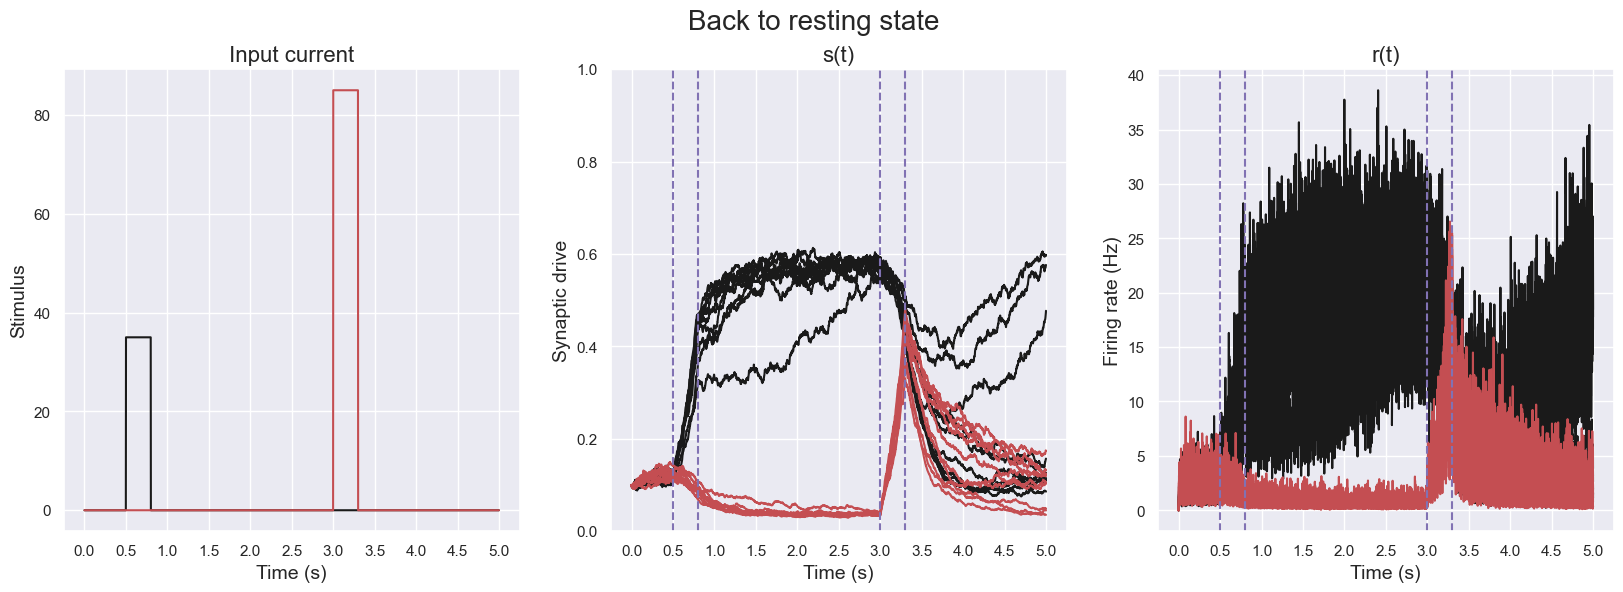

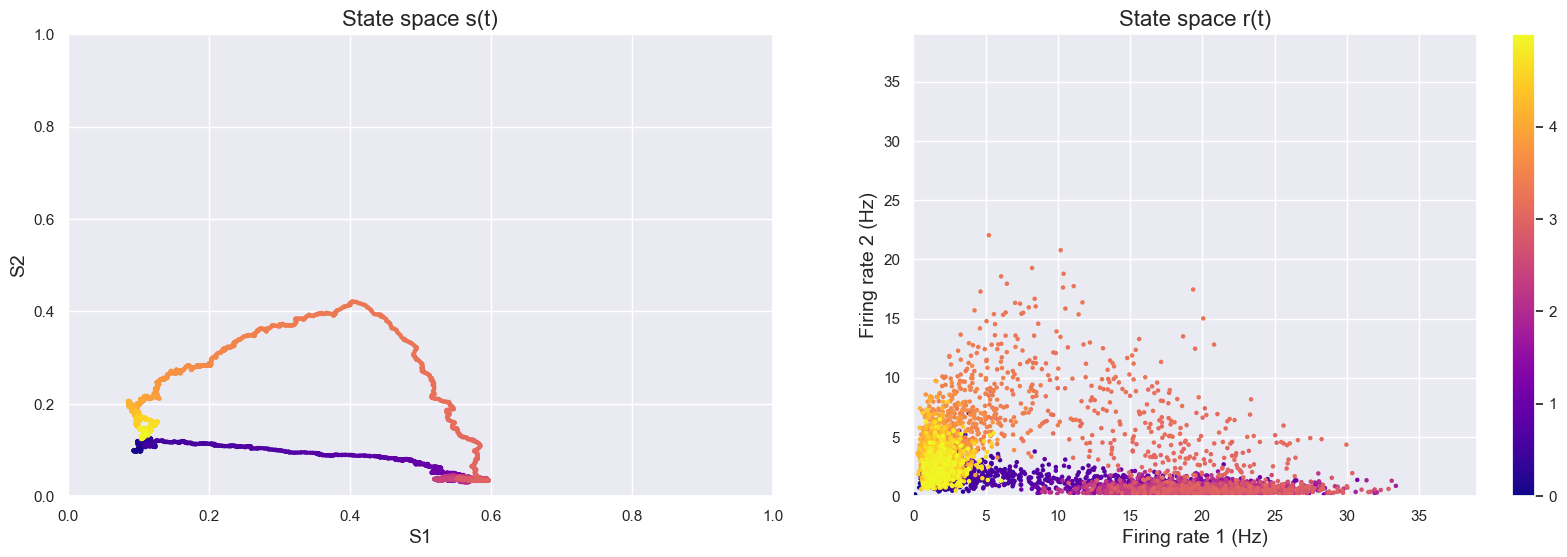

In [7]:
params = reset_params()
params['Tmax'] = 5
params['len_T'] = int(params['Tmax']/params['del_t'])
mu = np.zeros((2, params['len_T']))

t_stim = [[500, 800], [3000, 3300]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 35
for tt in range(t_stim[1][0], t_stim[1][1]):
    mu[1, tt] = 85
s,r = synaptic_dynamics(mu, params)
plot_fr_dynamics(r, s, mu, t_stim, '1b3', params, fdict)

##### In order to check the effect of the distractor on the dynamics, we first present stimulus 1 from 500 - 800 ms that results in persistent activity for population 1 while having baseline activity for population 2. A distractor of equal intensity is then presented for population 2 later in the delay, here from 1800 - 2100 ms. In most trials, we see that the synaptic drive for population 1 does not change much and remains high after the distractor is gone. In these trials, there is a slight bump in synaptic drive for population 2 that goes away once its gone. This translates to persistent activity for population 1 and baseline firing rate for population 2. And in the state-space, this corresponds to the synaptic drive remaining in high synaptic drive for population 1 and higher firing rate for population 2. In other trials, approximately <5% trials, when the persistenat activity for population 1 is not very high, the distractor does have an effect of switching the states wherein population 1 comes back to baseline, while population 2 goes to the persistent activity state.

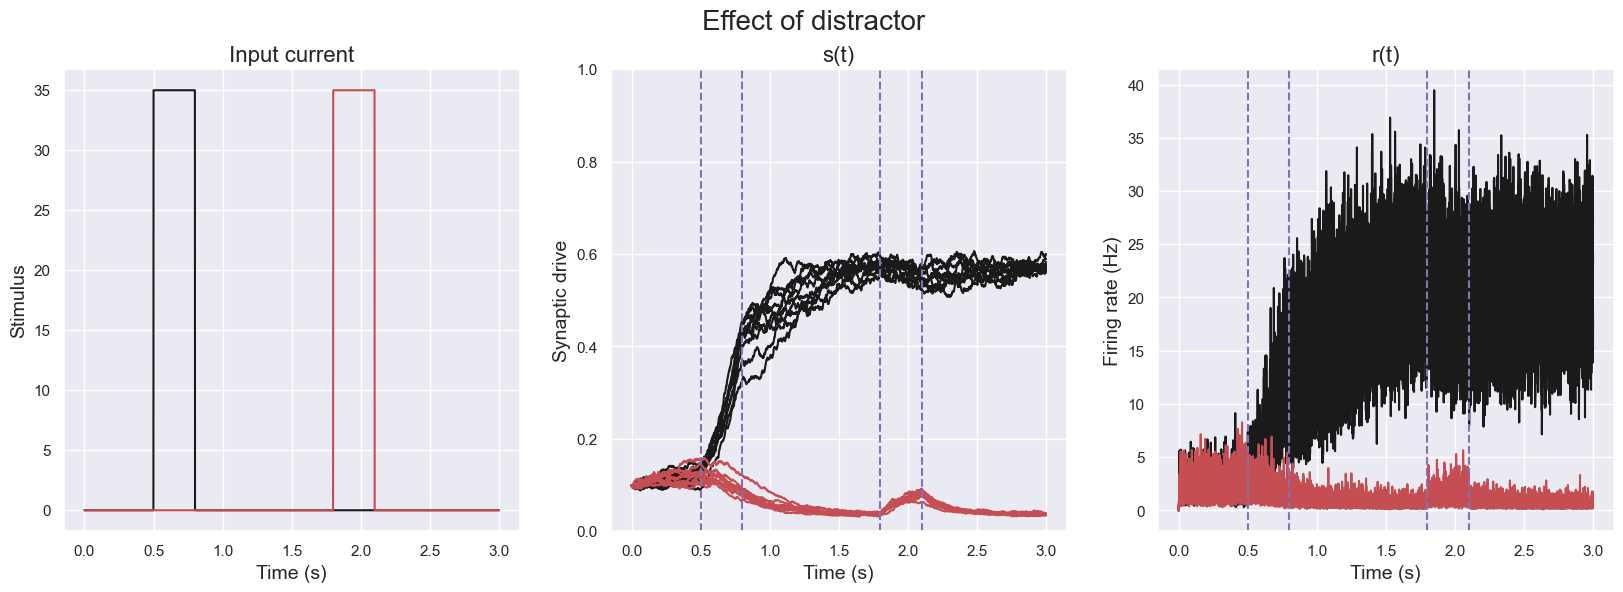

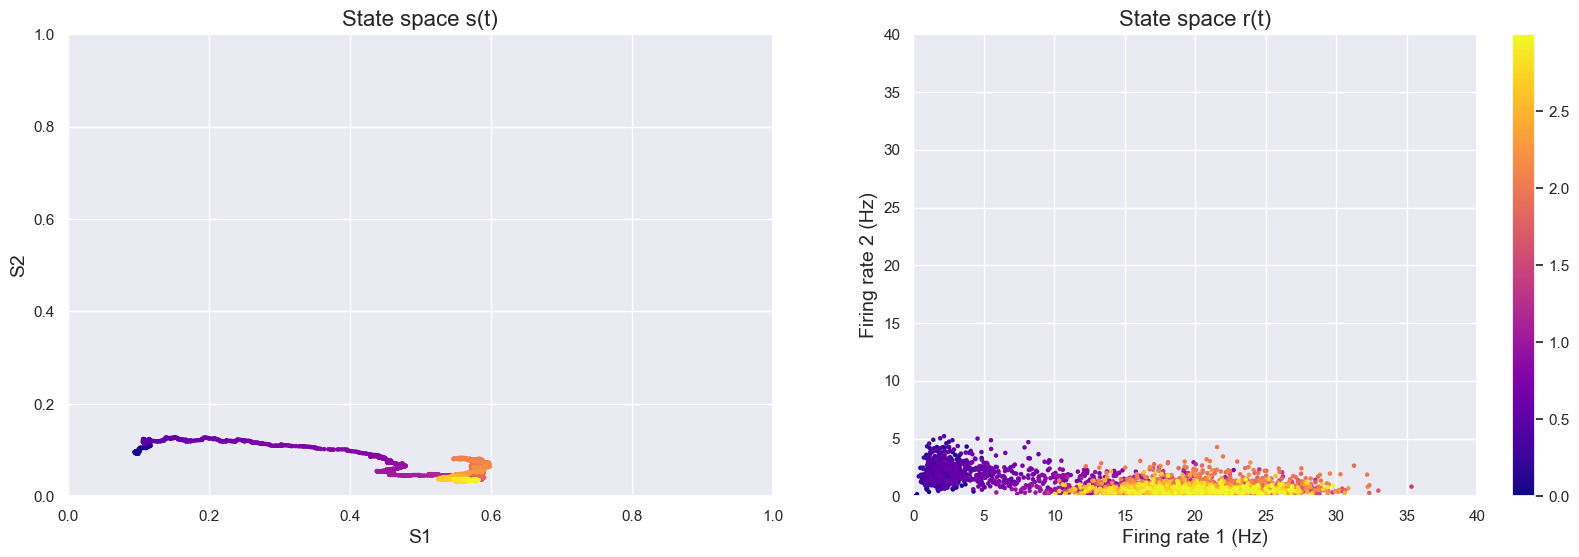

In [8]:
params['Tmax'] = 3
params['len_T'] = int(params['Tmax']/params['del_t'])
mu = np.zeros((2, params['len_T']))

t_stim = [[500, 800],[1800, 2100]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 35
for tt in range(t_stim[1][0], t_stim[1][1]):
    mu[1, tt] = 35
s,r = synaptic_dynamics(mu, params)
plot_fr_dynamics(r, s, mu, t_stim, '1d', params, fdict)

##### The parameter gE captures recurrent excitation that is essential to maintain the population in the persistent neural activity state once its firing rate increases because of the stimulus. Decreasing gE thus would decrease the ability of the population to remain in the persistent state. The question asks to decrease gE with steps of 0.01 nA, however, that seems to be too high a step size. Here, I have instead decreased gE with a step size of 0.001 nA while in each case, the population is only shown stimulus 1 but not stimulus 2. We can see that decreasing gE reduces the ability of the population to remain in the persistent attractor state, and the activity comes back to baseline faster and faster for lower values of gE. The threshold for which firing rate appears to reach baseline for all trials is gE = 0.25 nA.
##### Aside: I also tried increasing gE instead of decreasing it with a step-size of 0.01 nA, the results were cool. At very high values of gE, we can see that both the populations reach a high firing rate persistent state irrespective of the population being stimuluated, which is similar to the marginal state from the previous assignment.

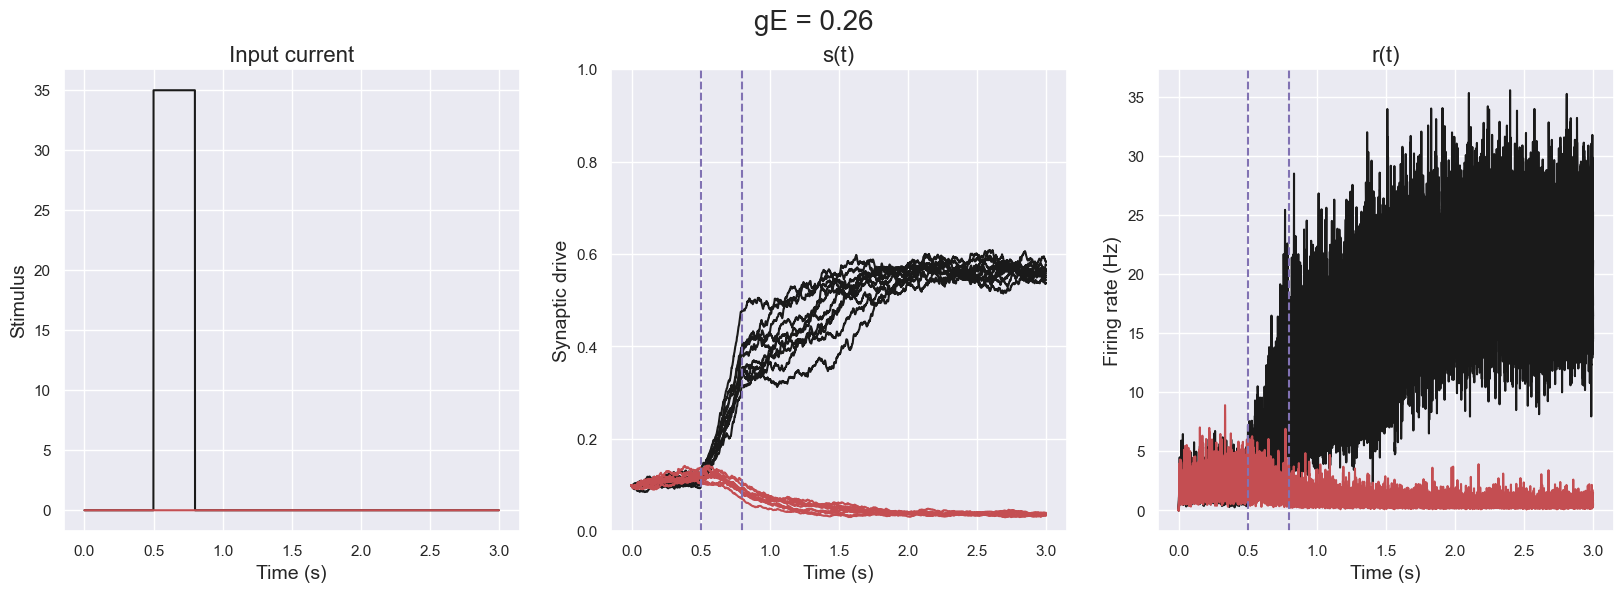

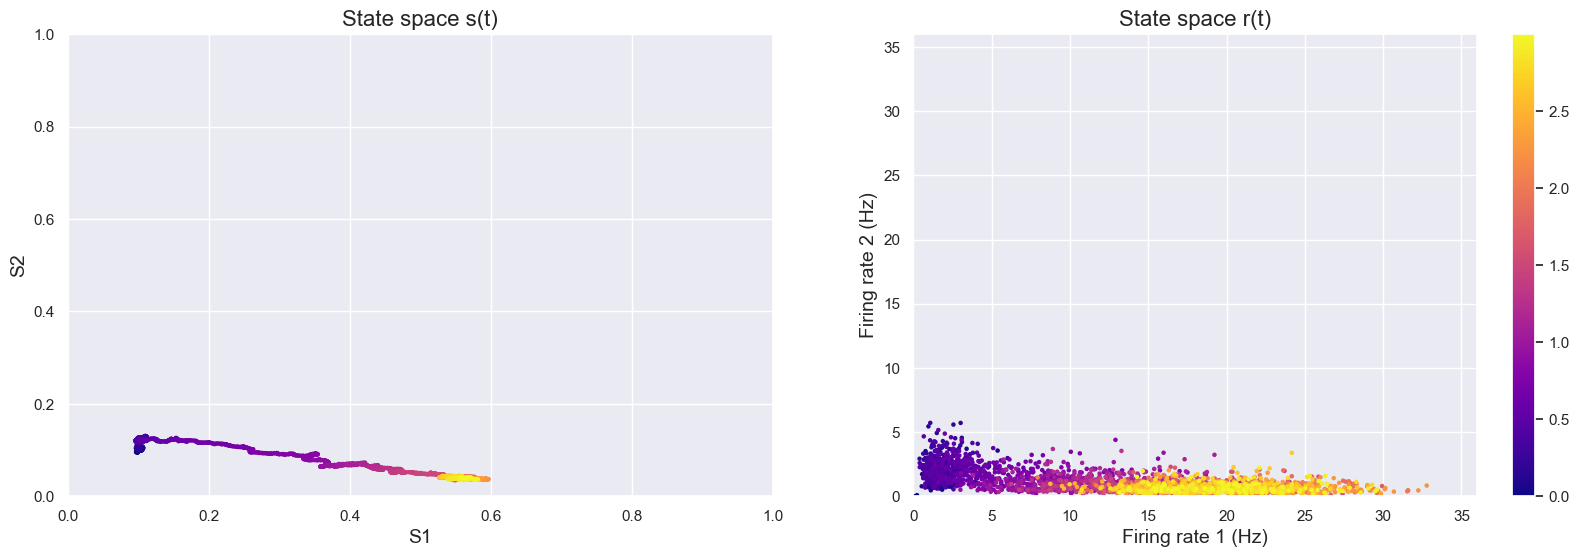

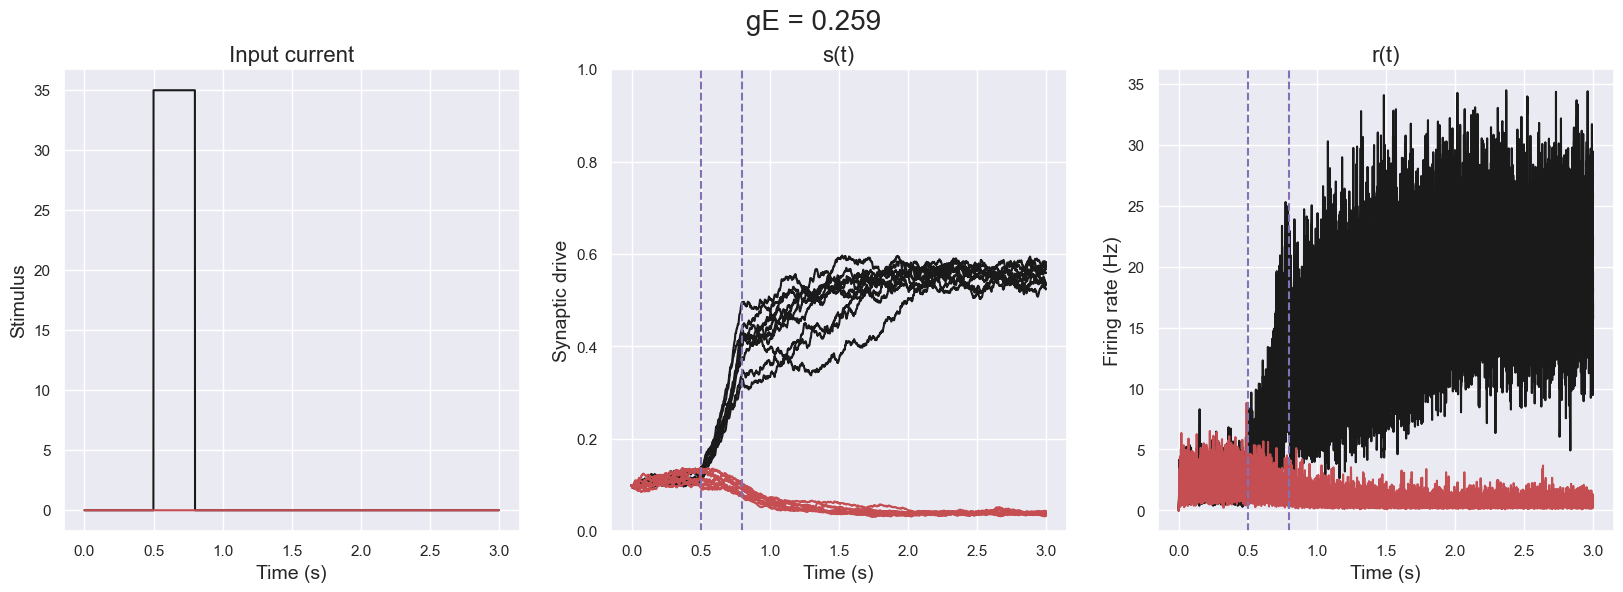

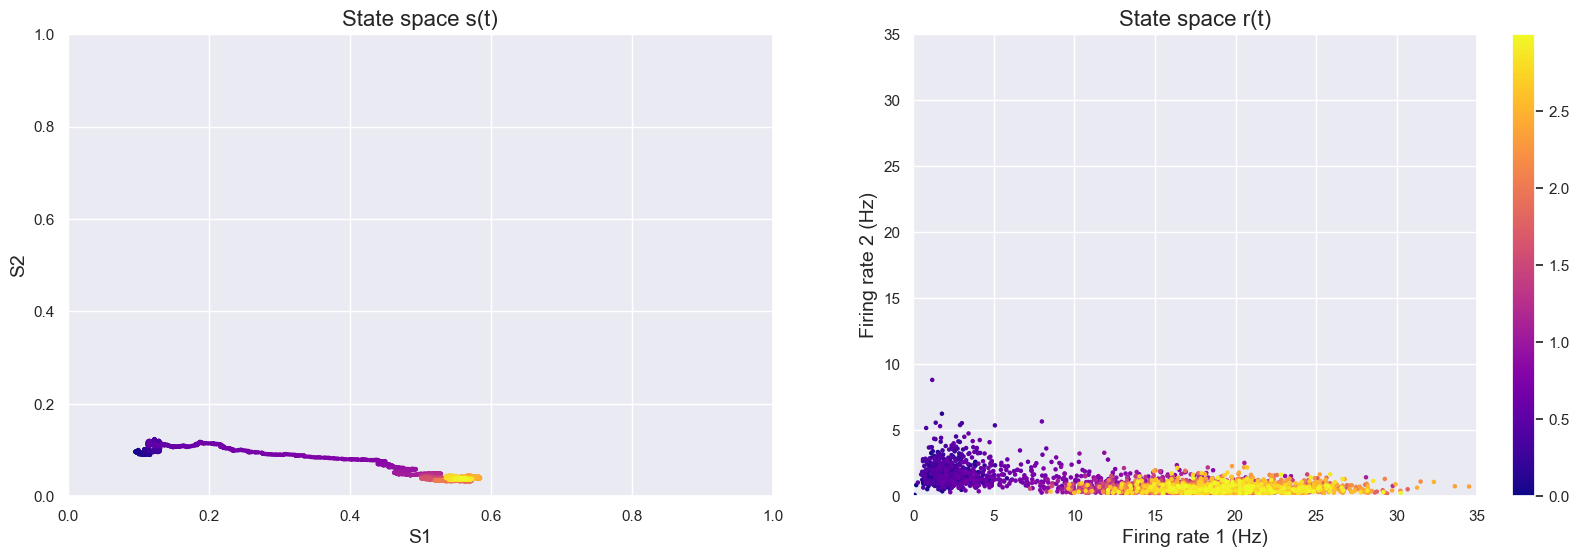

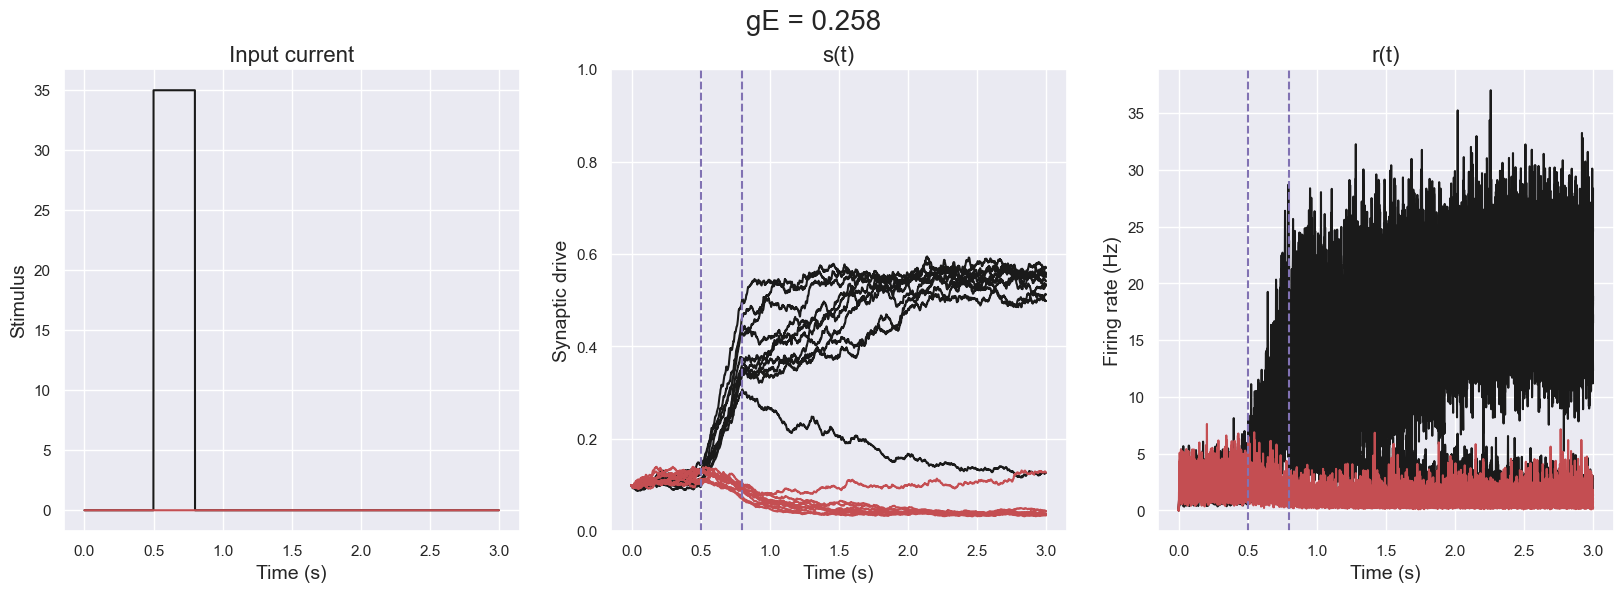

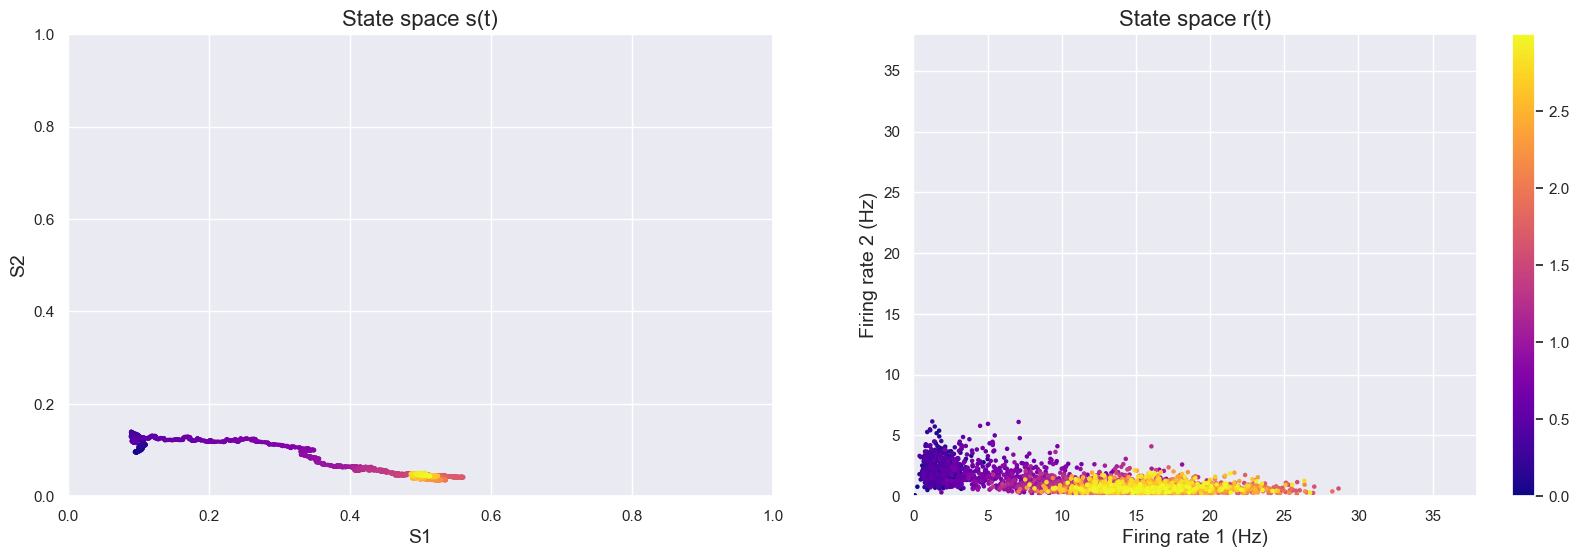

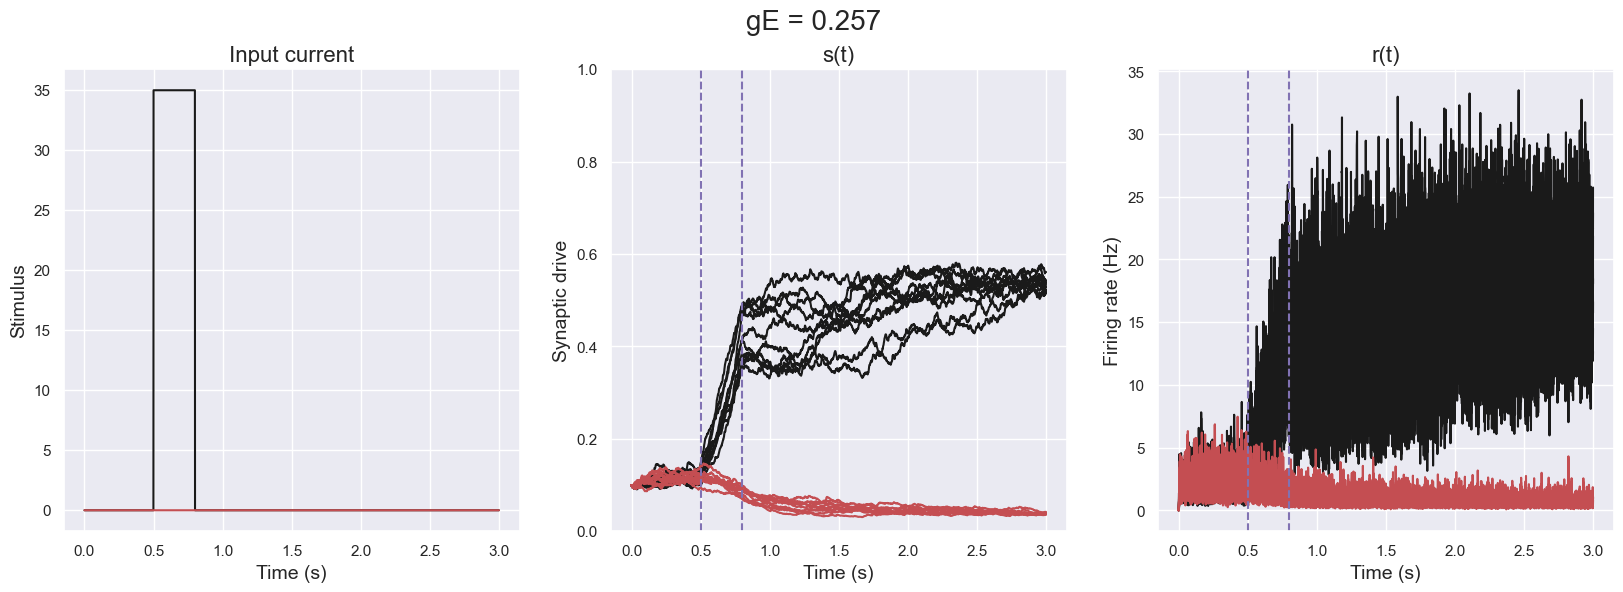

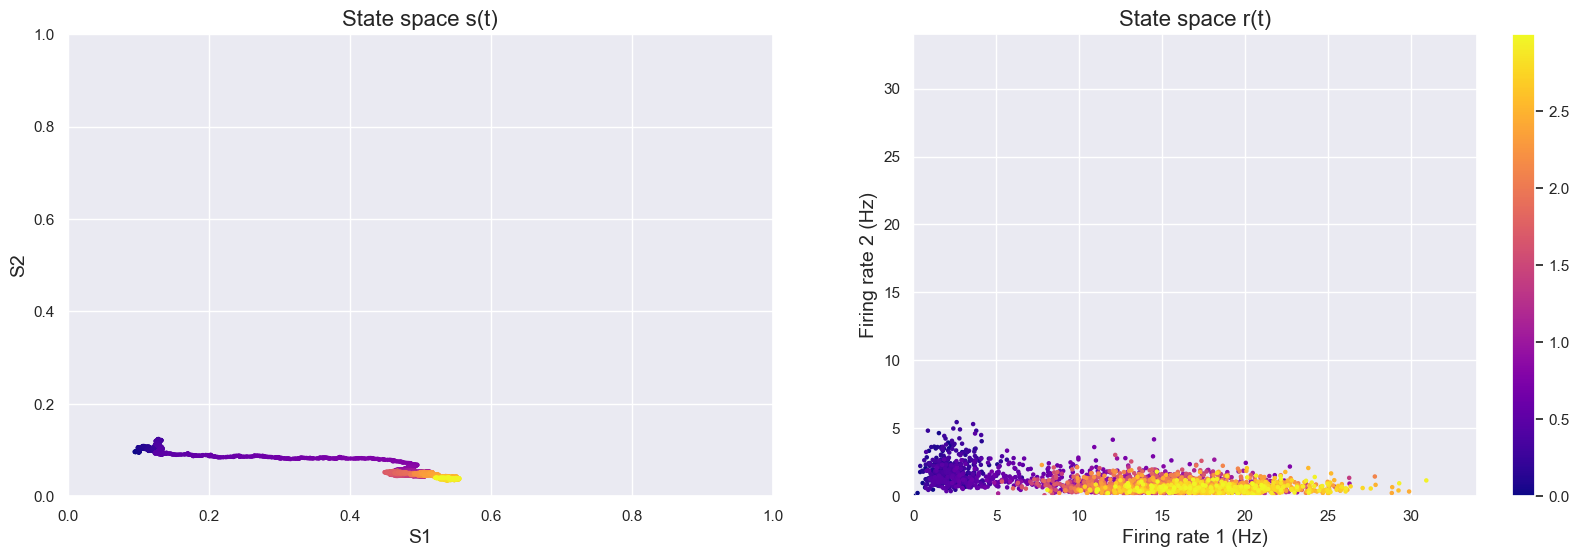

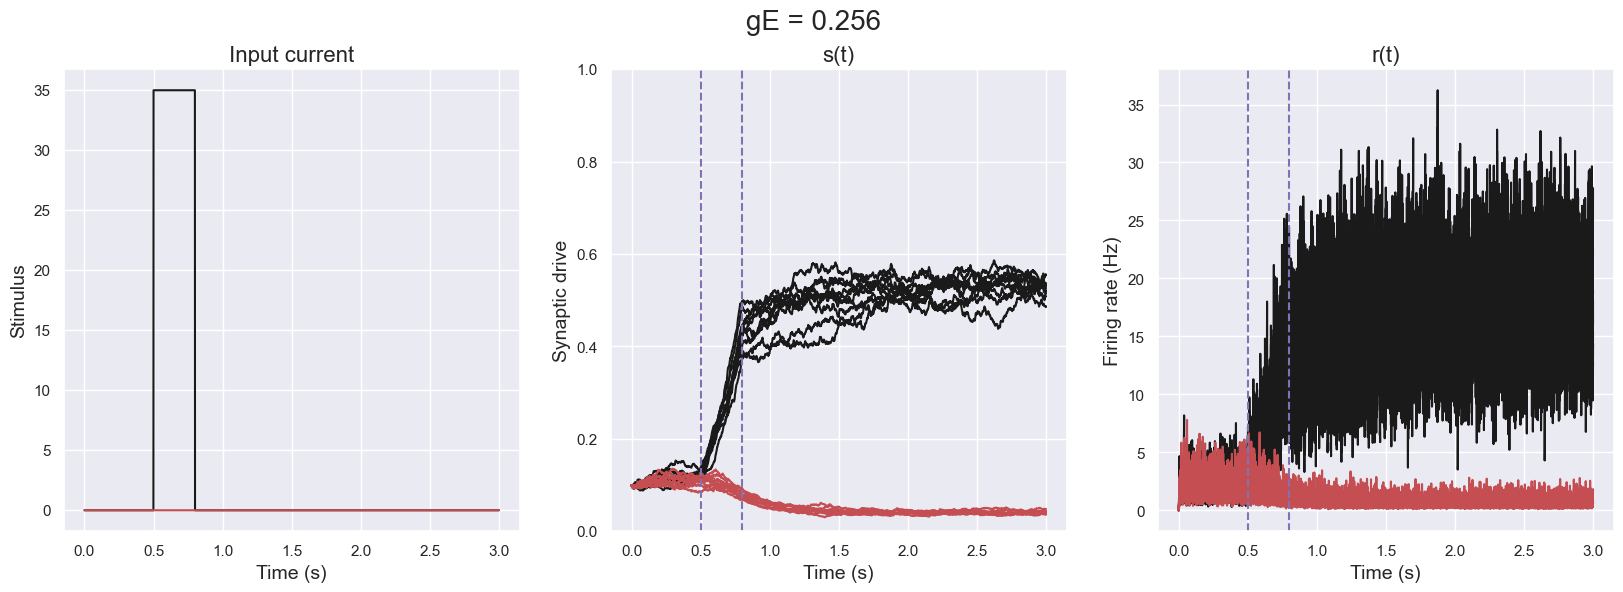

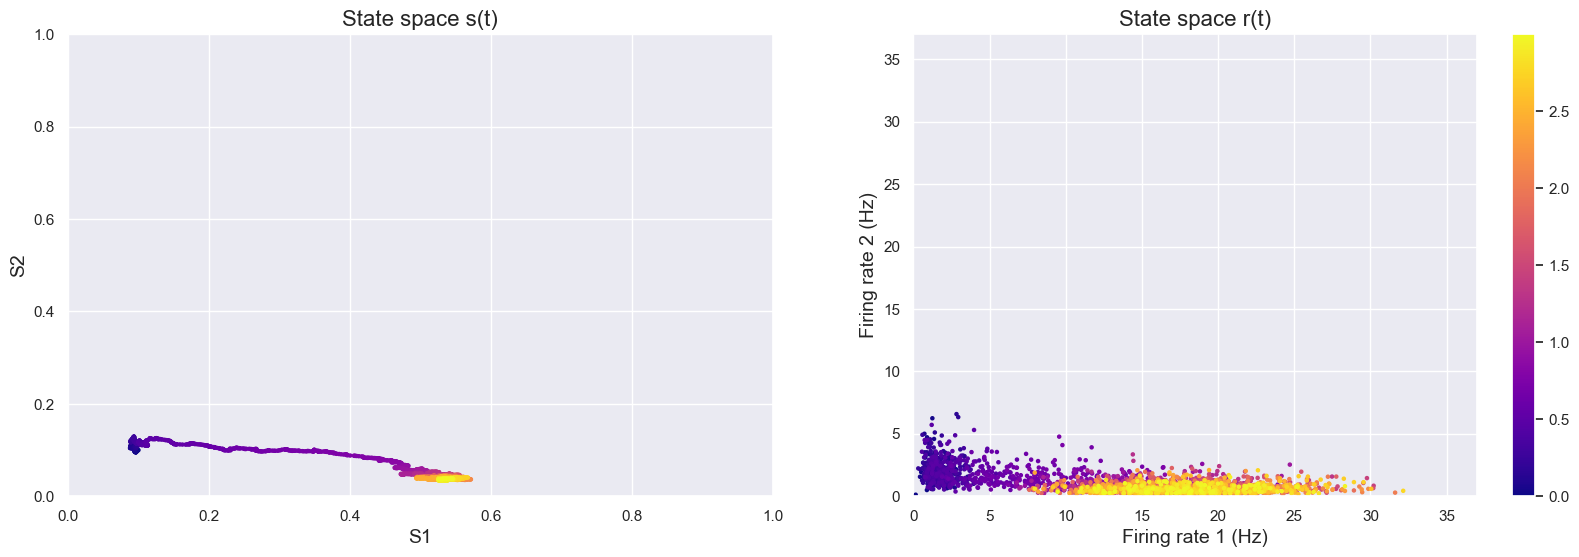

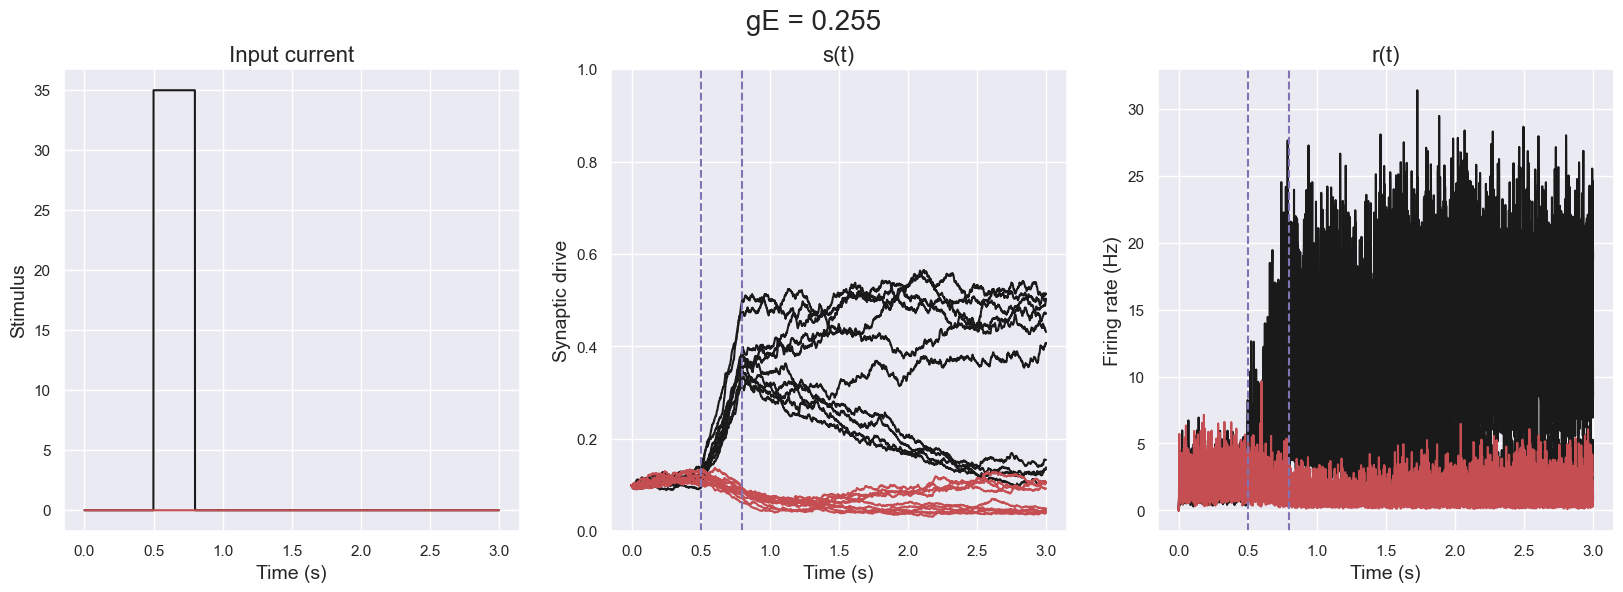

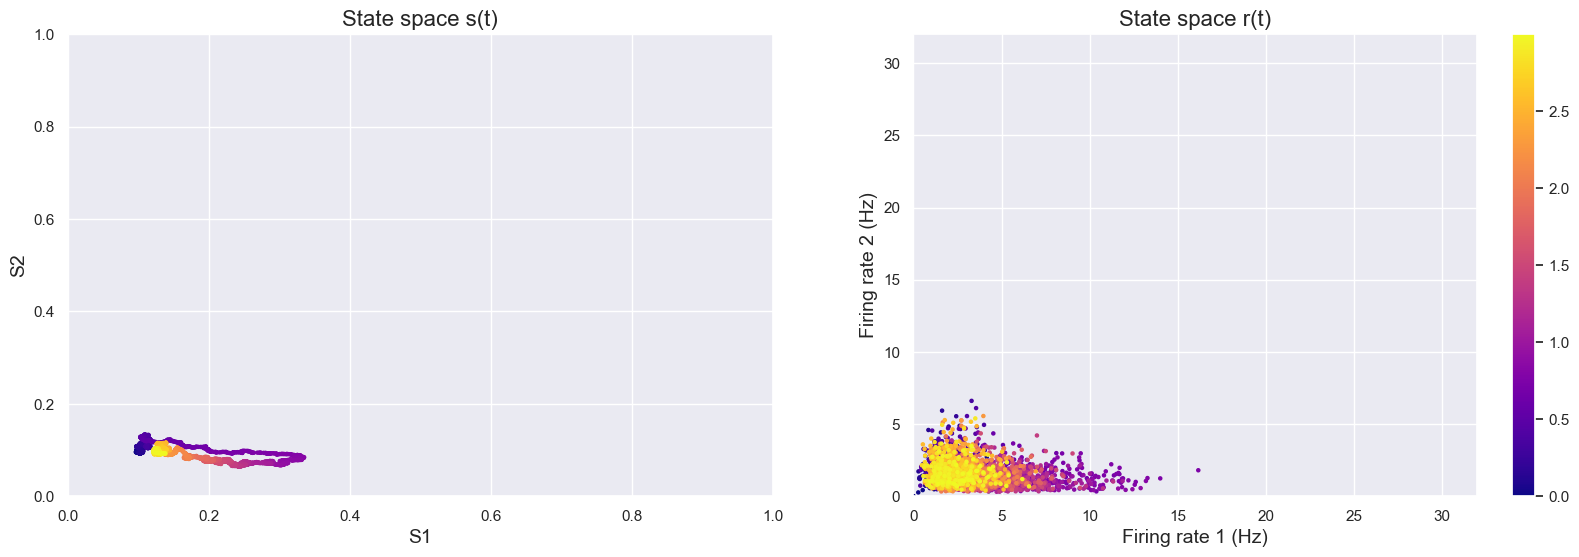

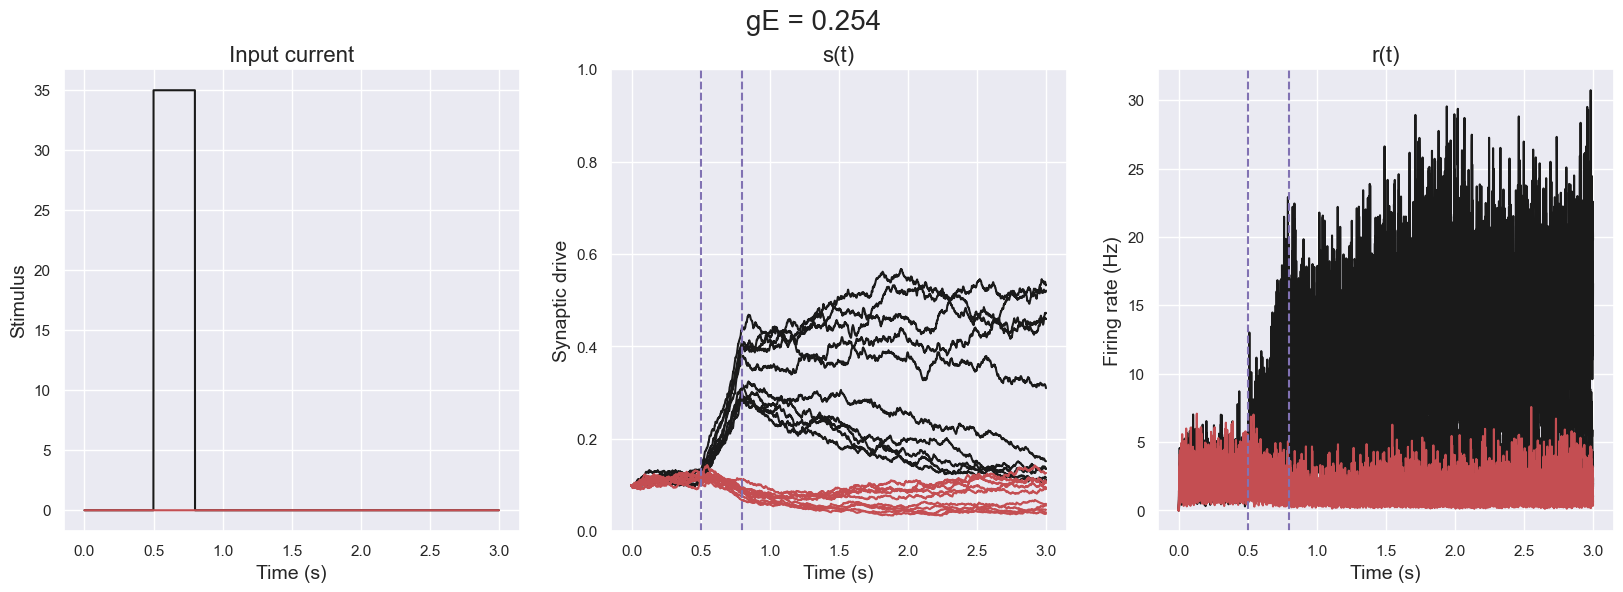

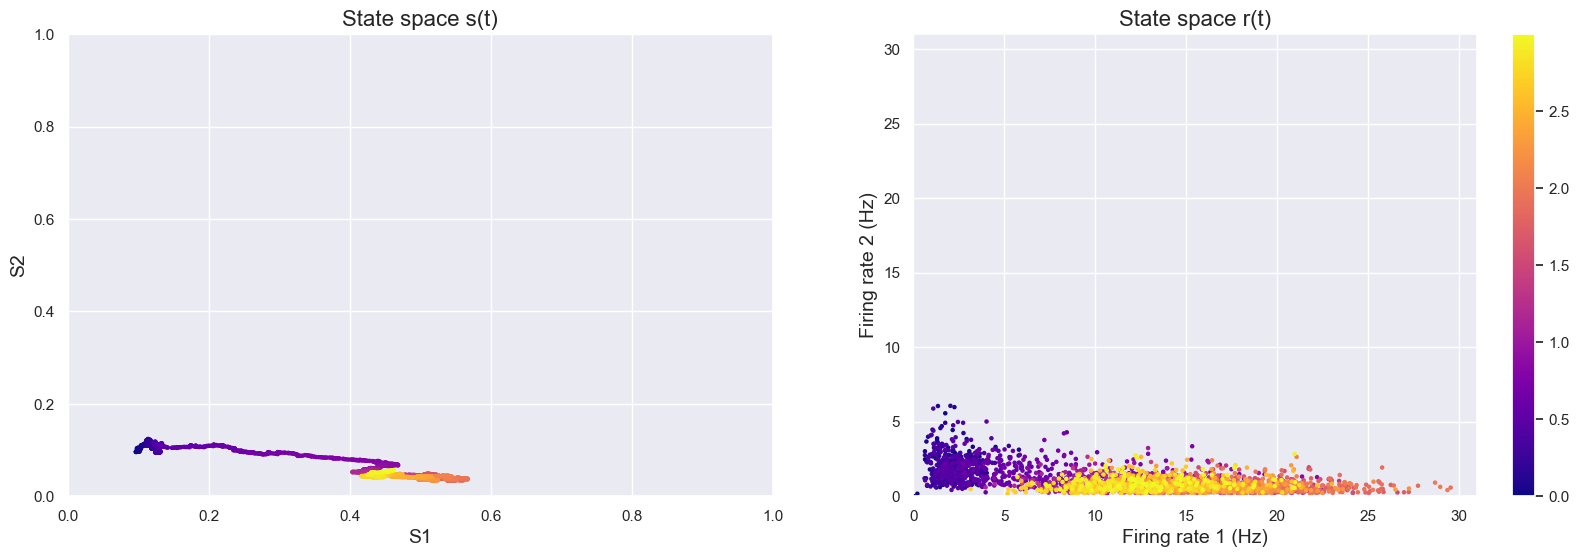

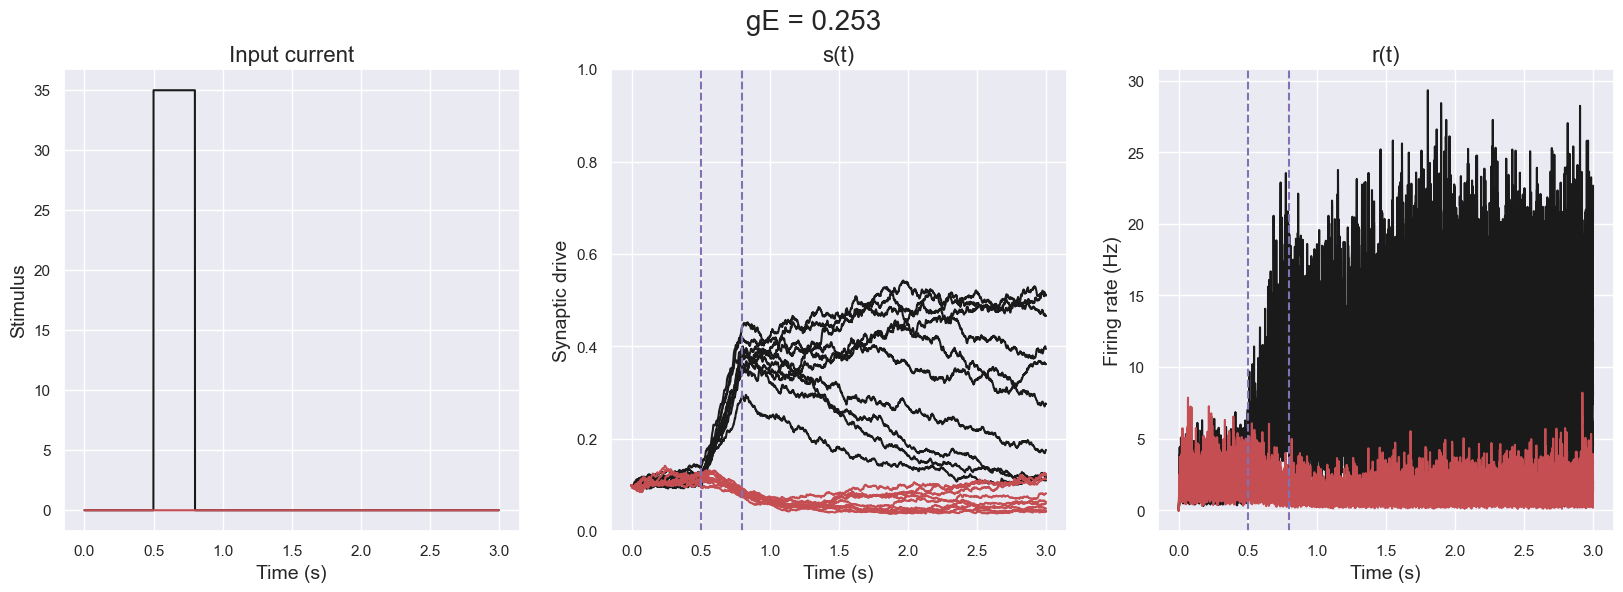

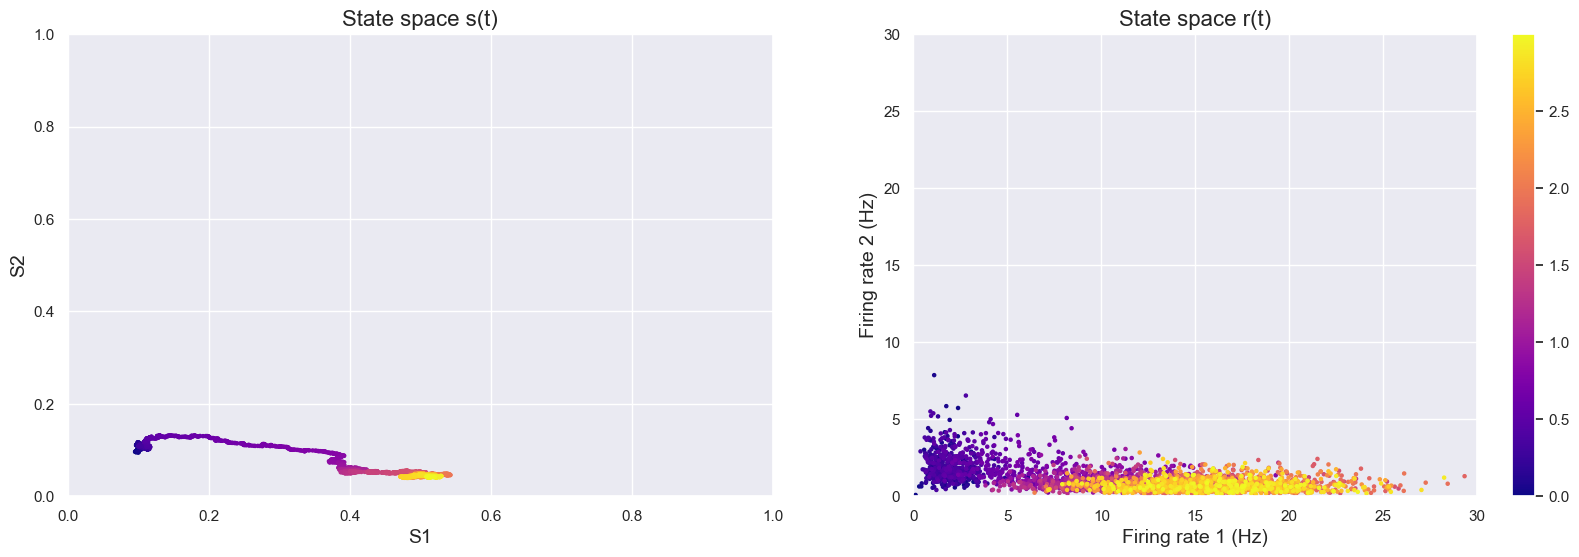

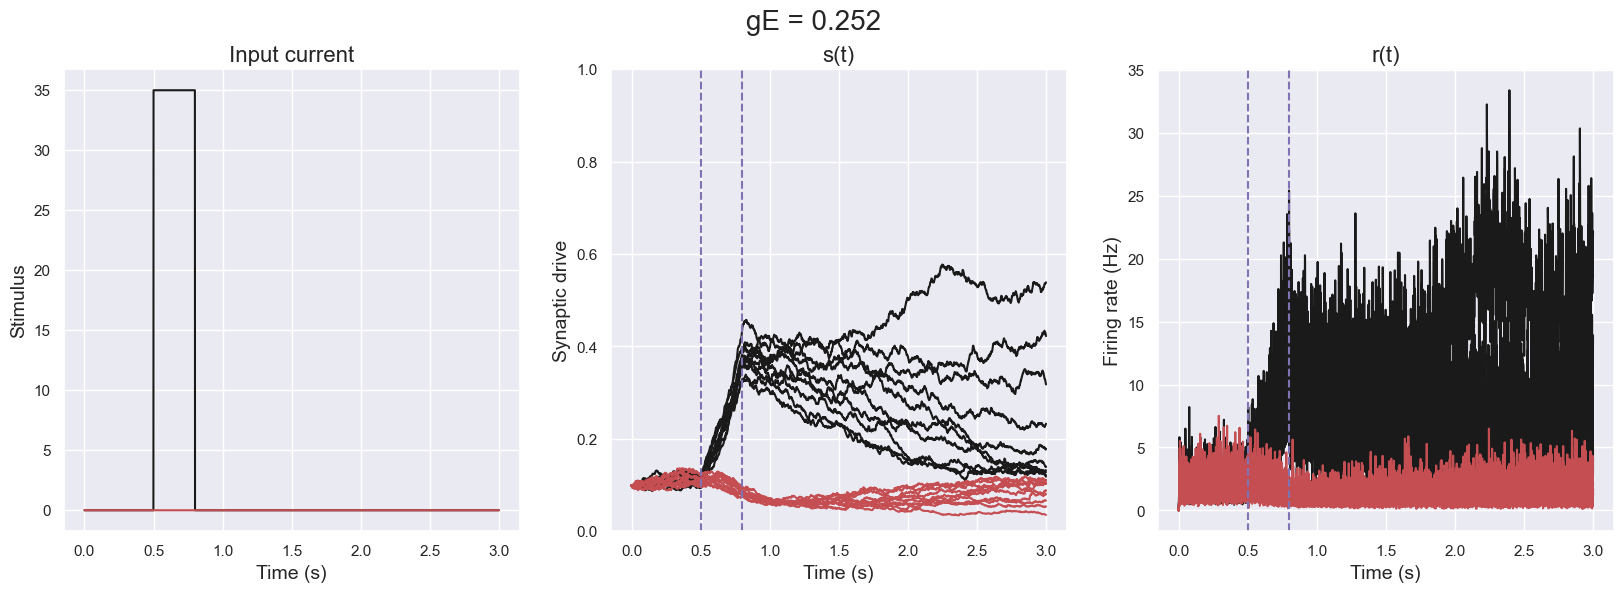

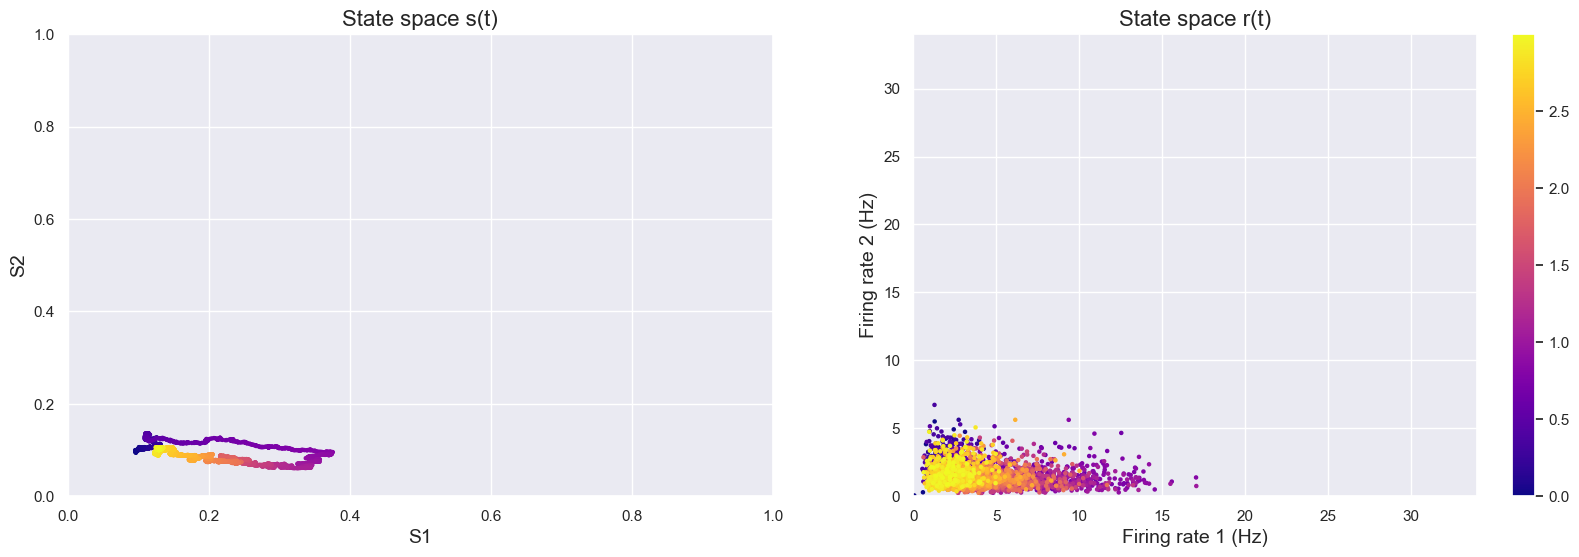

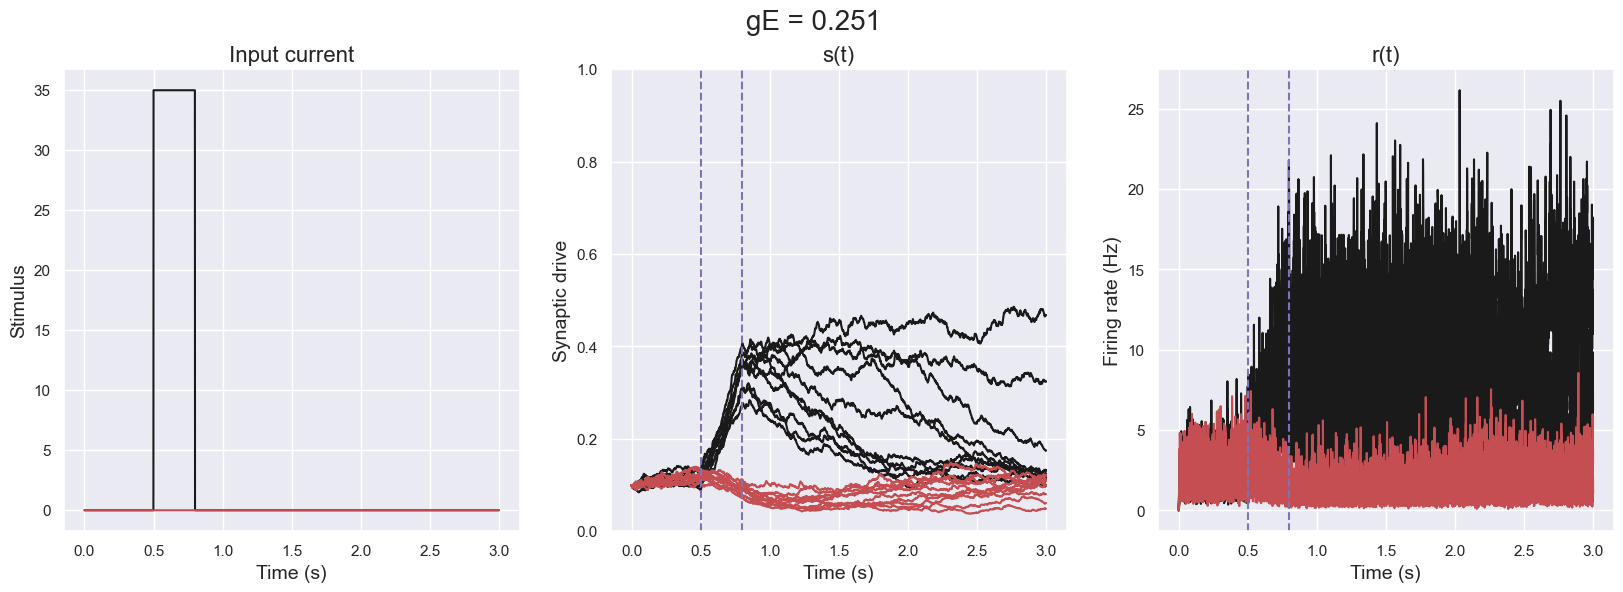

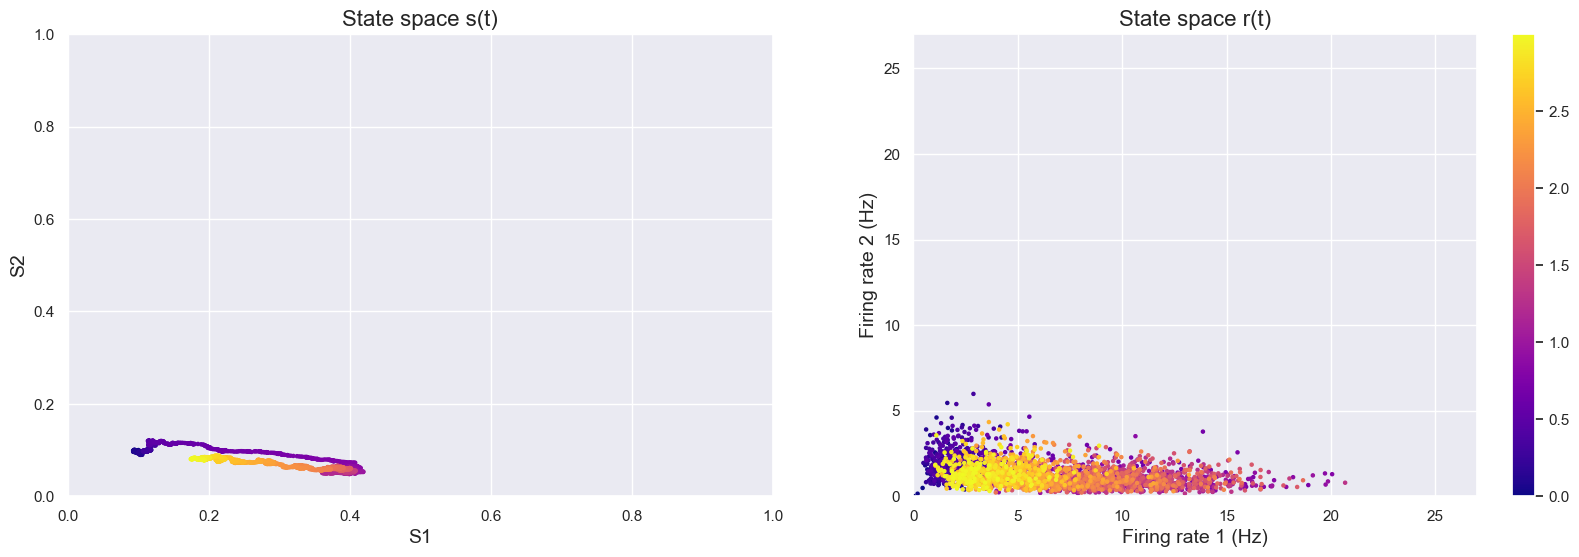

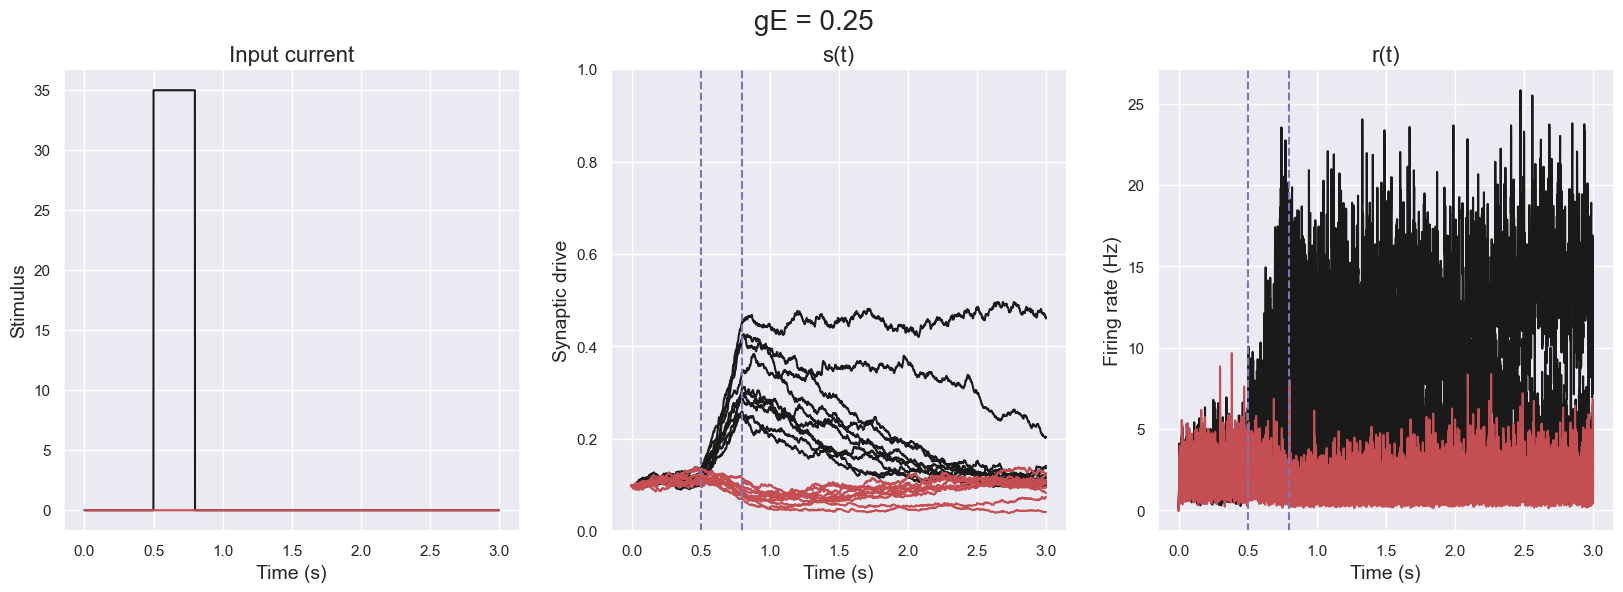

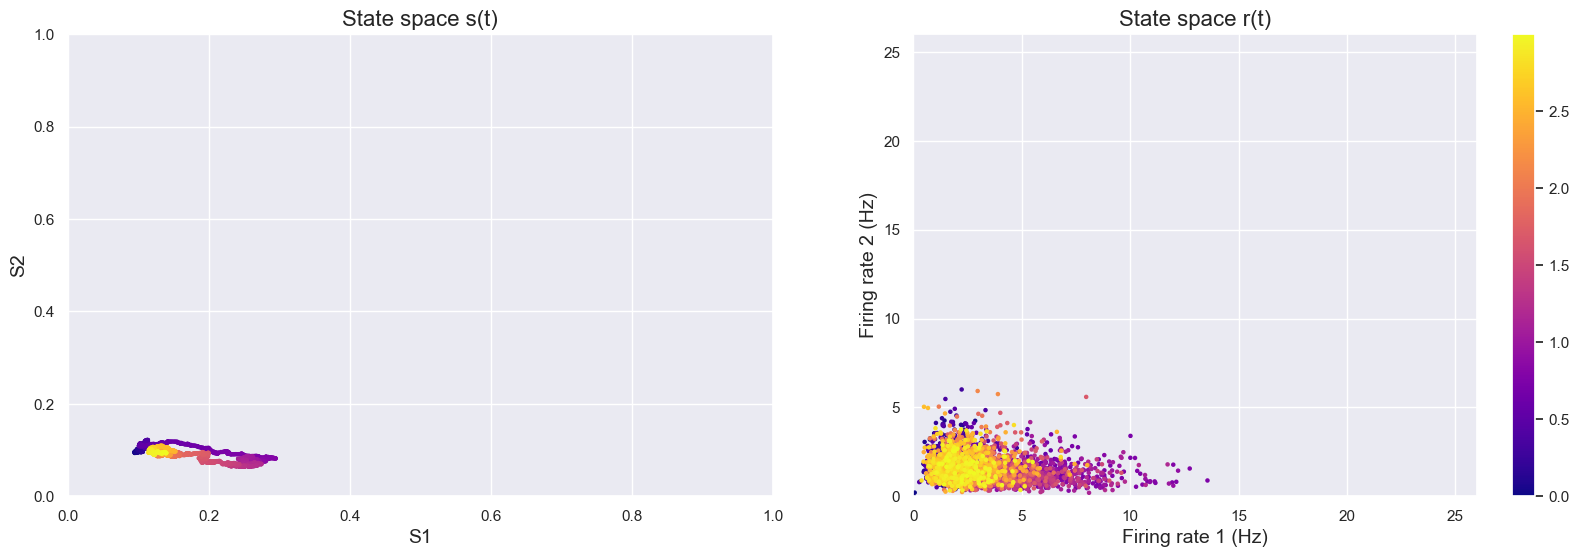

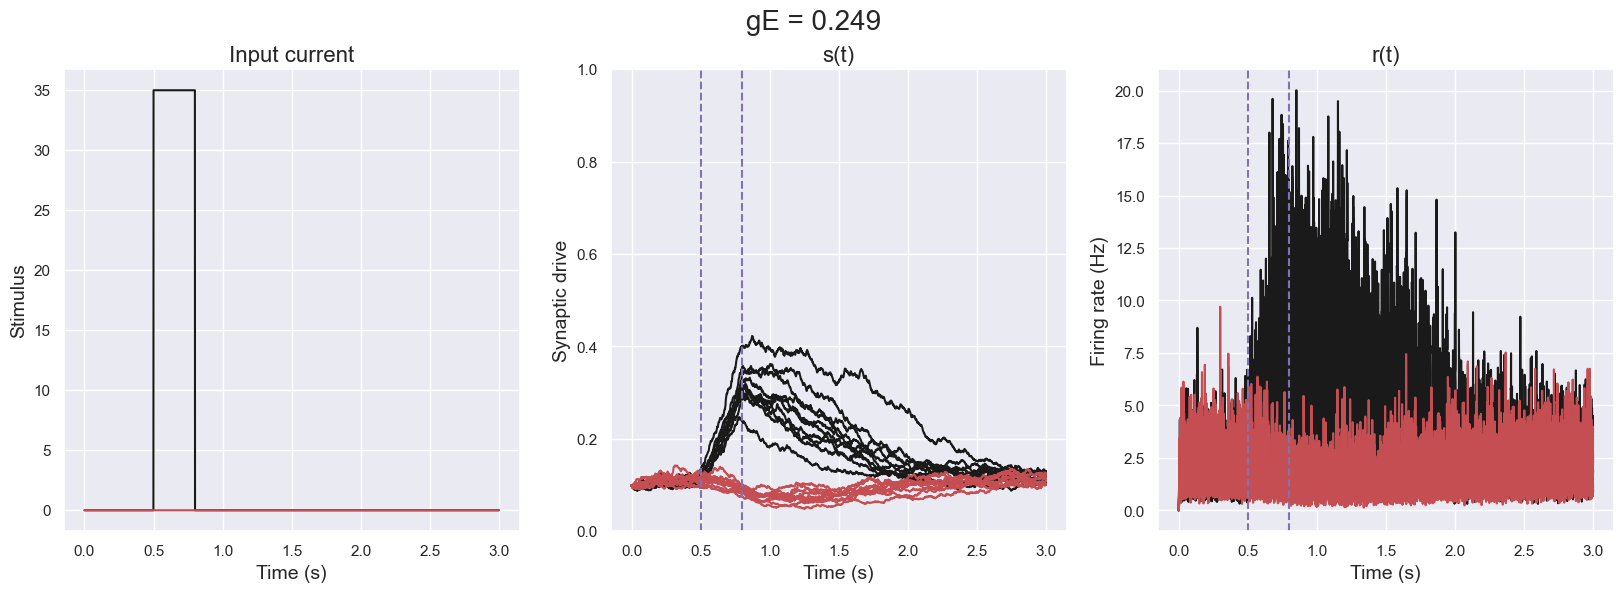

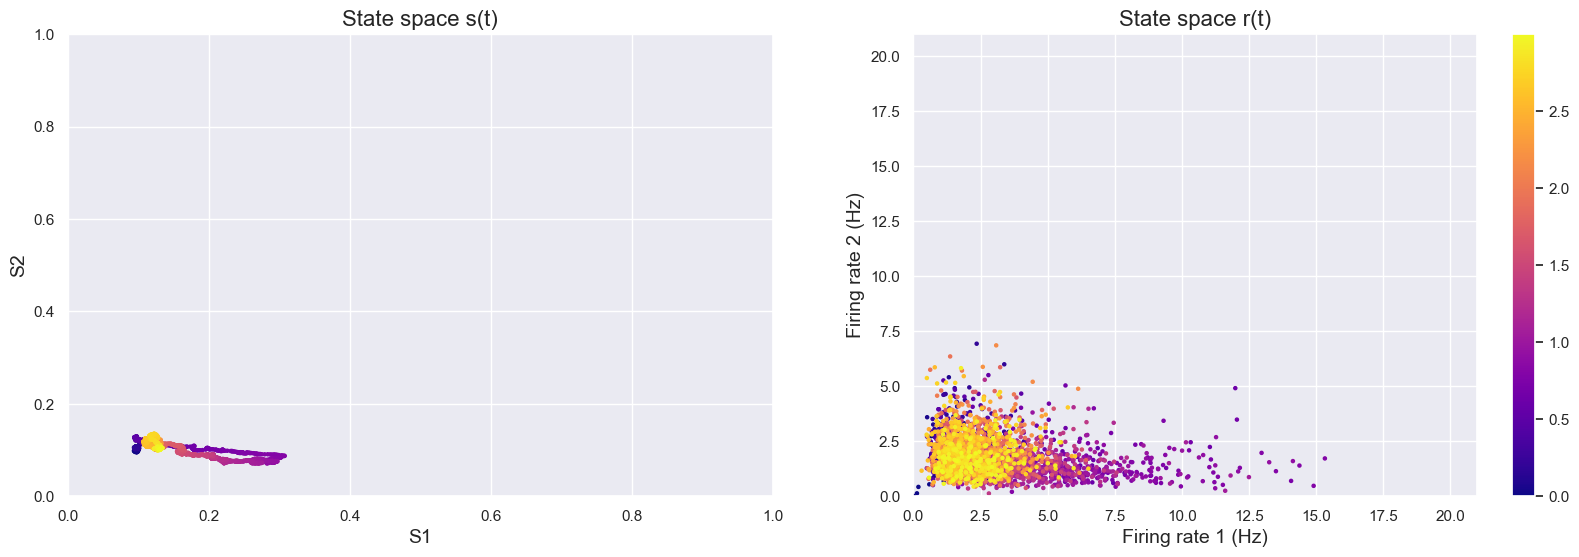

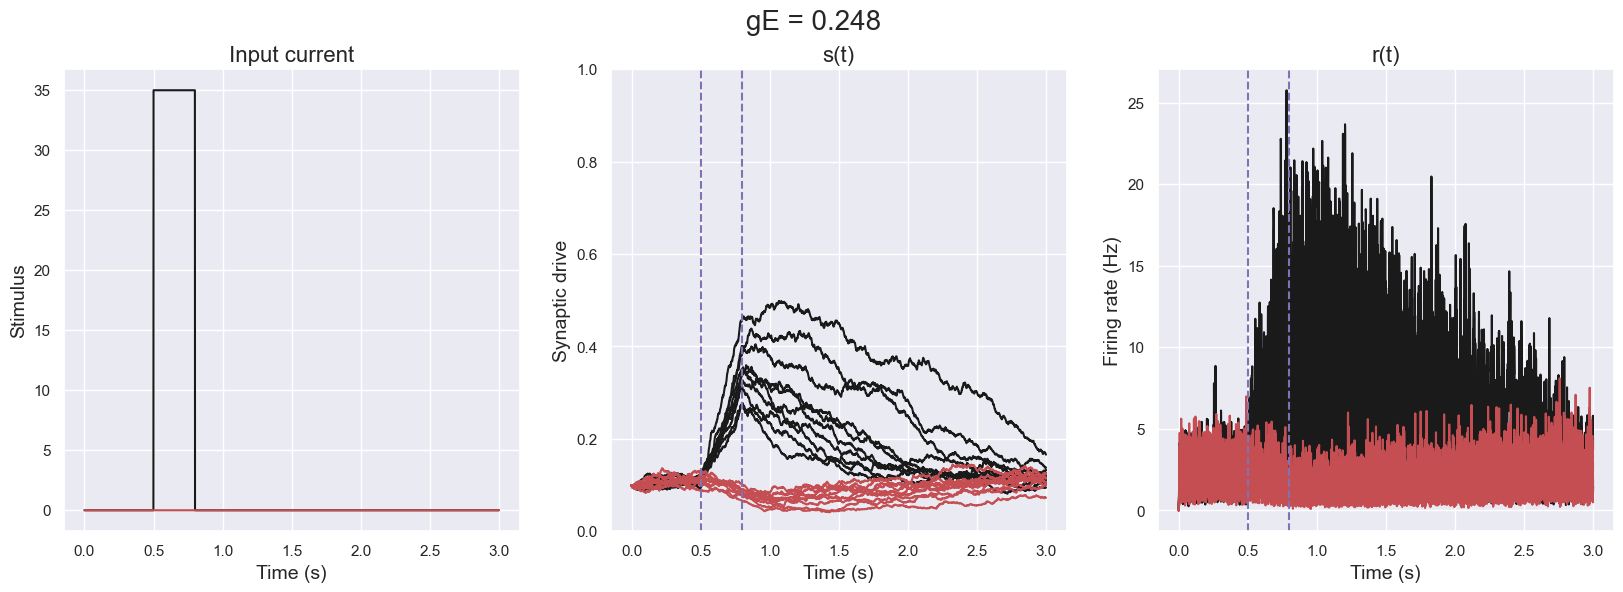

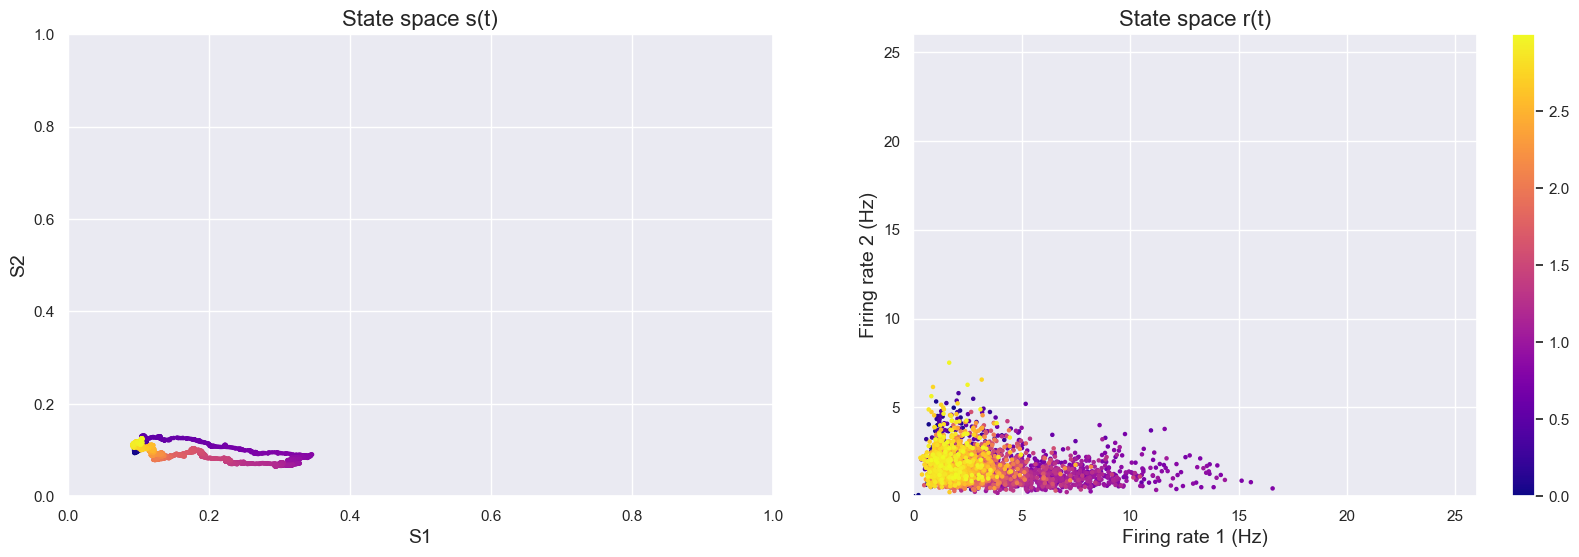

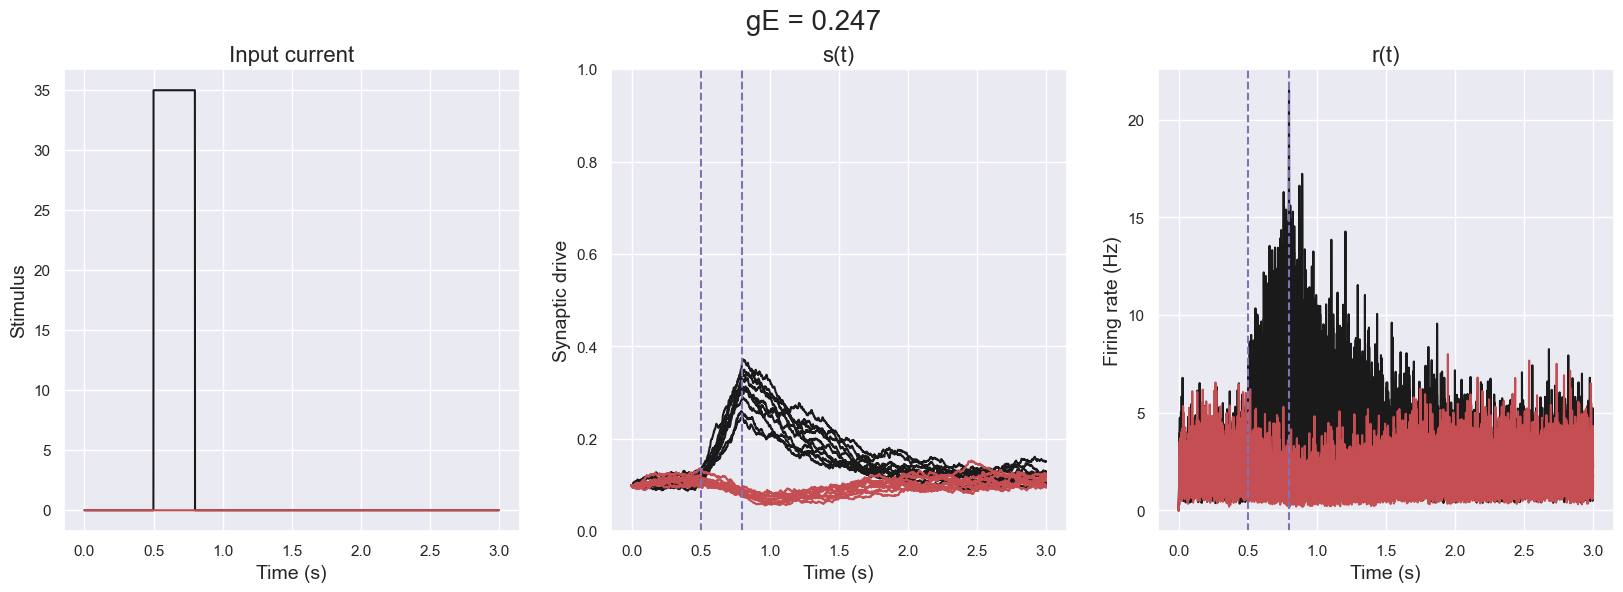

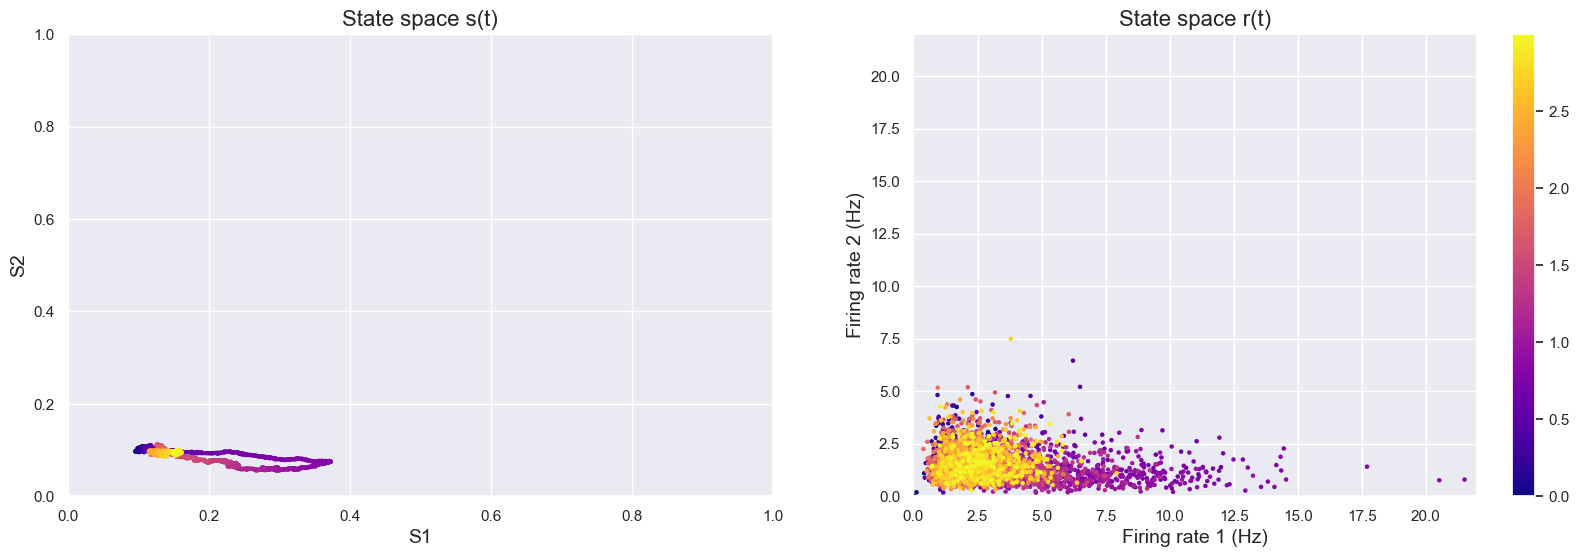

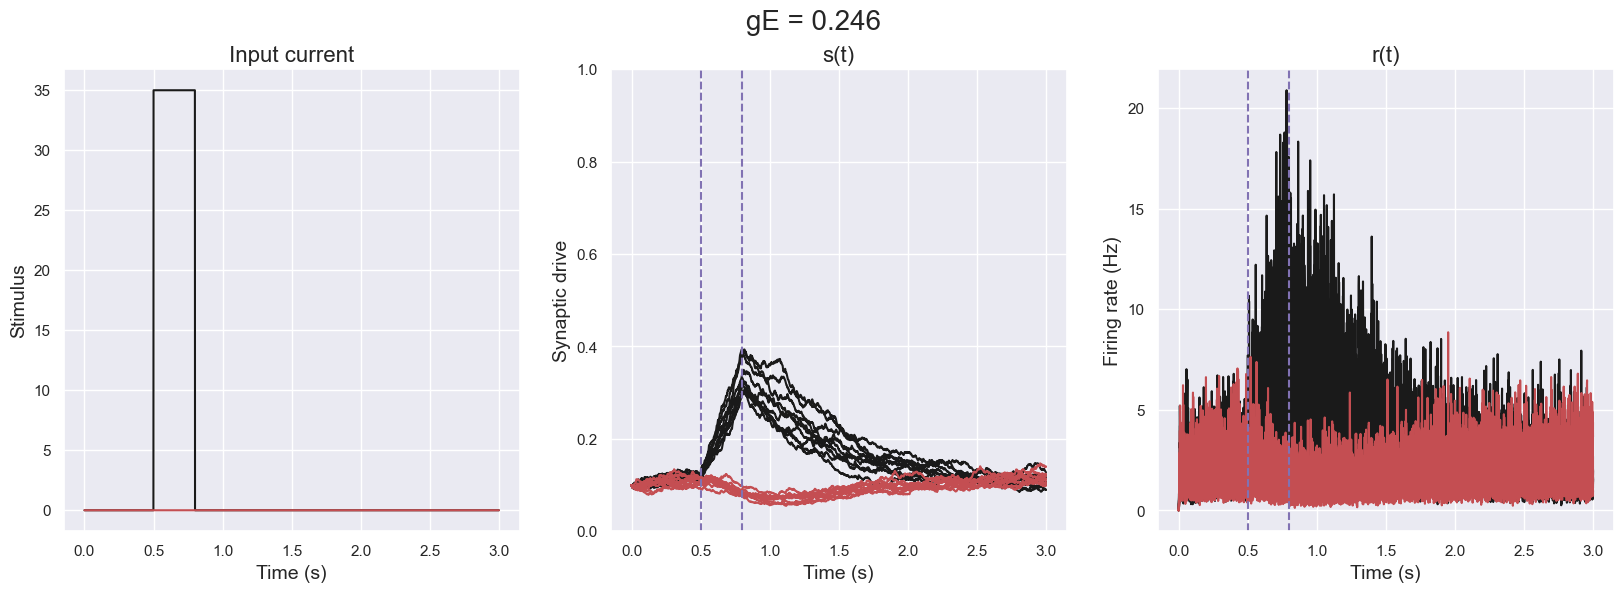

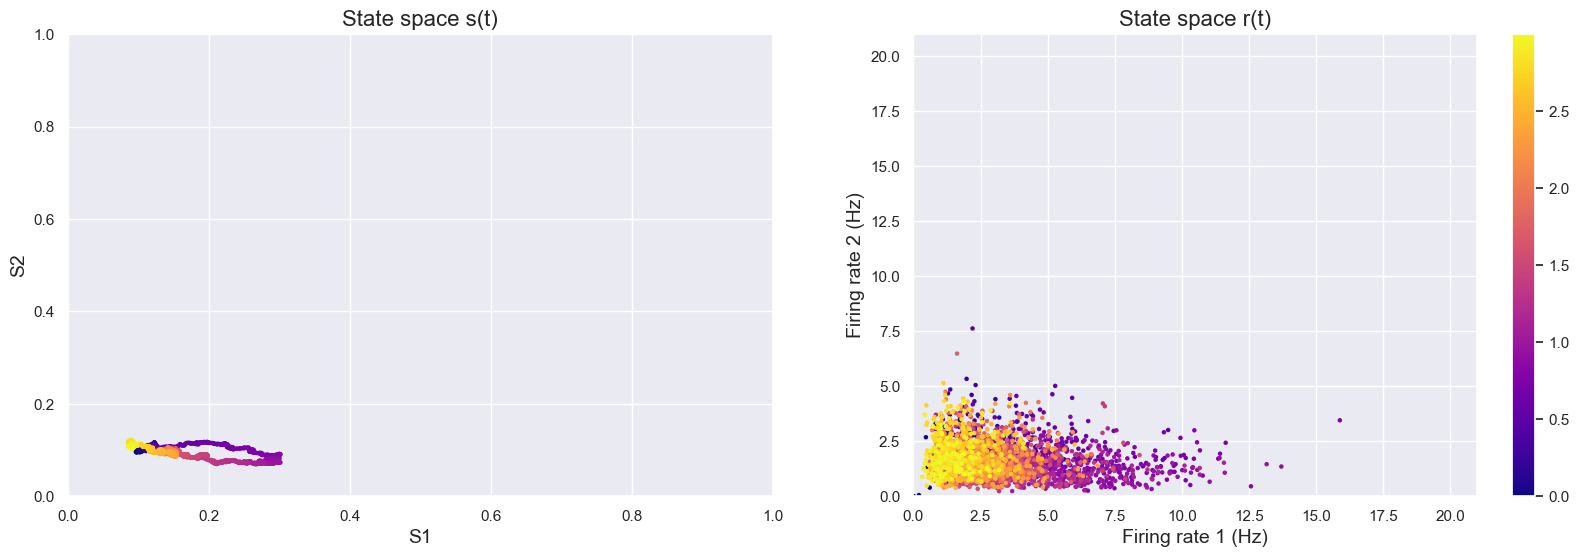

In [9]:
params = reset_params()
for blurb in range(15):
    params['gE'] -= 0.001
    mu = np.zeros((2, params['len_T']))
    t_stim = [[500, 800]]
    for tt in range(t_stim[0][0], t_stim[0][1]):
        mu[0, tt] = 35
    s,r = synaptic_dynamics(mu, params)
    plot_fr_dynamics(r, s, mu, t_stim, '1e', params, fdict)

#### Q2. 'Coin-tossing' simulations with $\mu_1 = \mu_2 = \mu_0 - 30 (c^{'} = 0) $. In a decision-making simulation, both $\mu_1 $ and $\mu_2 $ are presented for a time interval, say from $t_1 = 500 $ ms to $t_2 = 1500 $ ms ($T = t_2 - t_1 = 1 sec $), and your total simulation time should be much longer (say 3 sec). The decision choice is determined according to which of the two active attractors wins the competition. In different (n) trials (each with a different seed for the random number generator, but always with the same initial condition $s_1 = s_2 = 0.1$), what do you observe? Do you see 50-50 decision outcome if n is large, say n = 100-500?

##### Using the same model to perform a decision making task, we can make a behavioral/choice read-out based on which of the two populations reaches the persistent activity i.e. high firing rate state. When both the stimuli are shown at the same intensity, we can see that for some trials, population 1 has a high firing rate and attains persistent neural activity whereas the population 2 remains in the low firing rate. In other trials, population 1 remains in the baseline state whereas population 2 attains the persistent activity state. Therefore, on the former trials, choice of 1 is made, whereas on the latter trials, choice of 2 is made. Repeating the simulation for a higher number of trials, say n = 500, we can see that the two choices are equally probable.

Number of trials for which choice is 1 is 5
Number of trials for which choice is 2 is 5


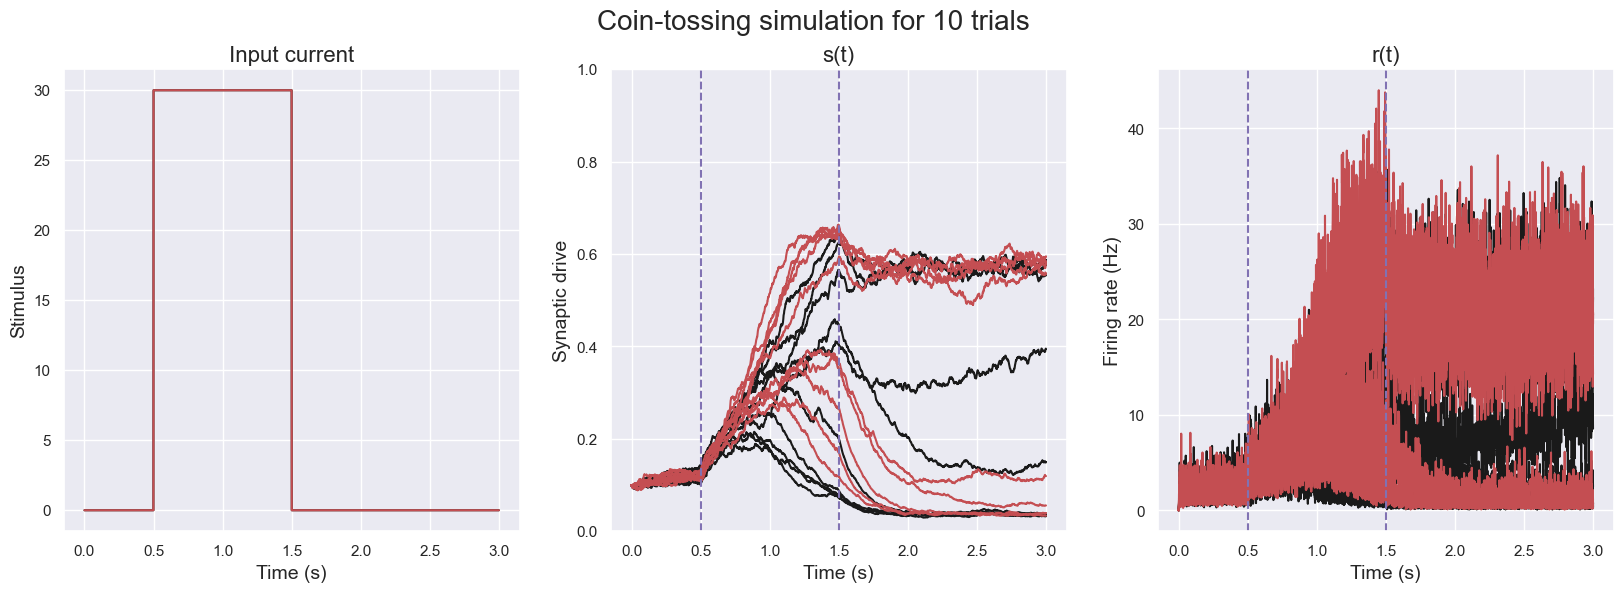

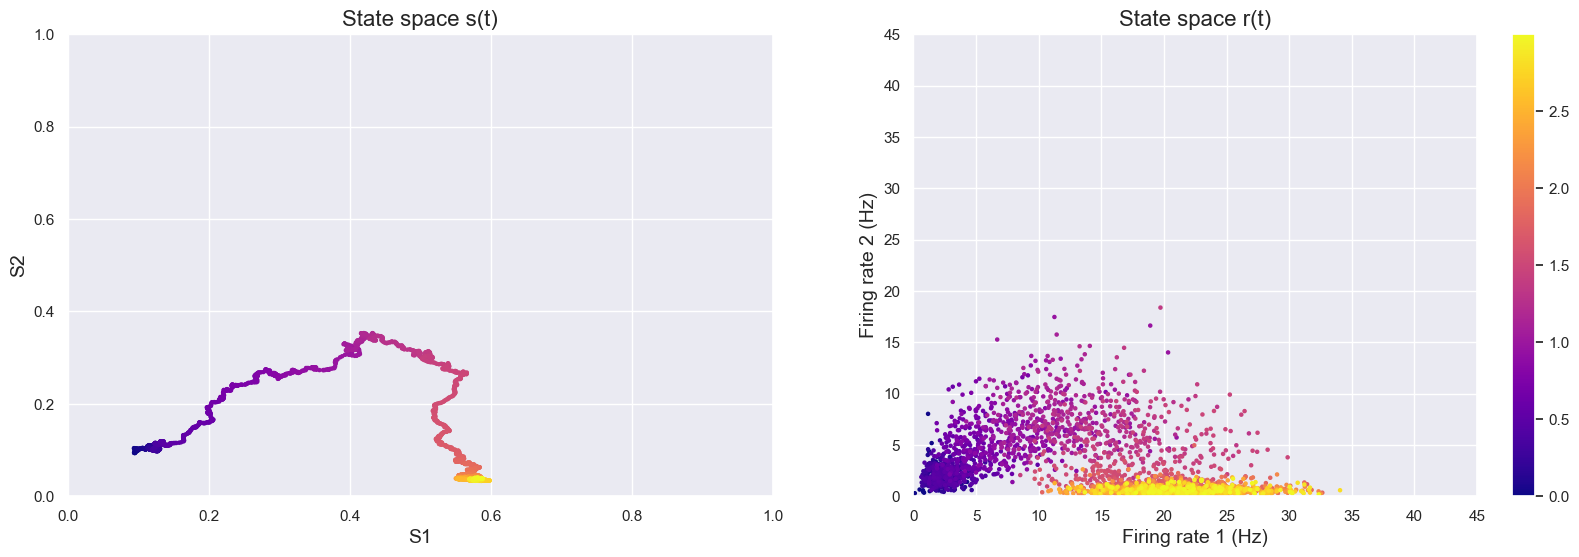

In [10]:
params = reset_params()
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 1500]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 30
    mu[1, tt] = 30
s,r = synaptic_dynamics(mu, params)
choice = np.zeros((params['ntrials'],), dtype = 'int')
for trial in range(params['ntrials']):
    if r[0, -2, trial] < r[1, -2, trial]:
        choice[trial] = 1
    elif r[0, -2, trial] > r[1, -2, trial]:
        choice[trial] = 2
print(f'Number of trials for which choice is 1 is {np.sum(choice == 1)}')
print(f'Number of trials for which choice is 2 is {np.sum(choice == 2)}')
plot_fr_dynamics(r, s, mu, t_stim, '2', params, fdict)

In [11]:
params = reset_params()
params['ntrials'] = 500
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 1500]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 30
    mu[1, tt] = 30
s,r = synaptic_dynamics(mu, params)
choice = np.zeros((params['ntrials'],), dtype = 'int')
for trial in range(params['ntrials']):
    if r[0, -2, trial] > r[1, -2, trial]:
        choice[trial] = 1
    elif r[0, -2, trial] < r[1, -2, trial]:
        choice[trial] = 2
print(f'Number of trials for which choice is 1 is {np.sum(choice == 1)}')
print(f'Number of trials for which choice is 2 is {np.sum(choice == 2)}')

Number of trials for which choice is 1 is 261
Number of trials for which choice is 2 is 239


#### Q3. Stimulus-specific stimuli are given by $\mu_1 $ and $\mu_2 $. The 'coherence level' is defined as $c^{'} = (\mu_1 - \mu_2)/(\mu_1 + \mu_2) $. For example, if $\mu_1 = 0.84 $ and $\mu_2 = 0.8 $, then $c^{'} = 0.0244 $ or $2.44 \% $. Repeat (2) with several $c^{'} = 0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1.0 $ (for example, with $\mu_1 = \mu_0 (1 + c^{'})) $ and $\mu_2 = \mu_0 (1 - c^{'}) $. Plot the 'psychometric function', namely the percentage of correct decisions (choice=1 is correct if $\mu_1 > \mu_2 $) as a function of $log(c^{'}) $.

##### Coherence is now incorporated to determine the mu's for the two inputs provided, with stimulus for population 1 being higher than for population 2 always. Hence, the correct choice is always 1. Simulating this over several trials, here n = 100, and computing the % correct trials for different coherence stimuli and plotting on log-scale, we can see that the accuracy is low for lower coherence inputs and increases as a function of increasing coherence.

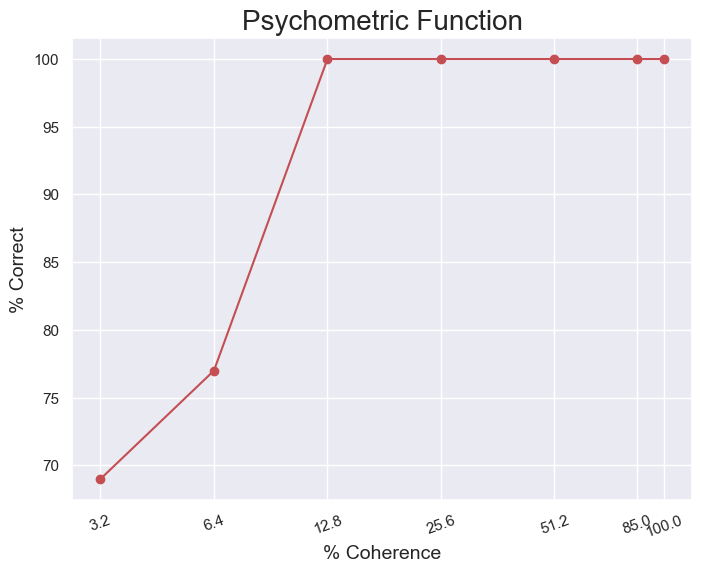

In [12]:
coherence = [0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1]
coh_100 = 100 * np.asarray(coherence)

percentage_correct = np.zeros(len(coherence),)
mu_0 = 30

params = reset_params()
params['ntrials'] = 100
for lol in range(len(coherence)):
    c = coherence[lol]
    mu = np.zeros((2, params['len_T']))
    t_stim = [[500, 1500]]
    for tt in range(t_stim[0][0], t_stim[0][1]):
        mu[0, tt] = mu_0 * (1 + c)
        mu[1, tt] = mu_0 * (1 - c)
    s,r = synaptic_dynamics(mu, params)
    choice = np.zeros((params['ntrials'],), dtype = 'int')
    for trial in range(params['ntrials']):
        if r[0, -2, trial] > r[1, -2, trial]:
            choice[trial] = 1
        elif r[0, -2, trial] < r[1, -2, trial]:
            choice[trial] = 2
    percentage_correct[lol] = 100 * (np.sum(choice == 1)/params['ntrials'])
plt.figure(figsize = (8, 6))
plt.plot(np.log(coherence), percentage_correct, 'ro-')
plt.xlabel('% Coherence', fontsize = fdict['axes'])
plt.ylabel('% Correct', fontsize = fdict['axes'])
plt.title('Psychometric Function', fontsize = fdict['stitle'])
plt.xticks(ticks = np.log(coherence), labels = coh_100, rotation=20)
plt.show()

#### Q4. Reaction time task. Set a firing threshold $\theta = 15 Hz $. In any trial, the decision is made whenever one of the two neural populations reaches this threshold first. Run simulations over many trials for each $c^{'} $ as in (3).
#### (a). Show sample time courses of firing rates for different coherence levels.
#### (b). Plot the psychometric function, namely the trial-averaged reaction time as a function of $ log(c^{'}) $
#### (c). Calculate the standard deviation of the reaction time, as a function of $ c^{'} $. Is the RT standard deviation proportional to its mean?
#### (d). Bonus: explore how the decision performance depends on time integration of sensory information, by computing the psychometric curve with varing durations of stimulus presentation (T = 100, 300, 500, 800 ms).

##### In order to bring in reaction-time (RT) into the model, we can make a choice whenever one of the populations has a firing-rate greater than a certain threshold in this case, reaches higher than 15 Hz. Plotting the population dynamics for different coherence level stimuli, we can see that at lower coherence levels, we can see a mix of increased firing rate for either populations more of at chance level. Increasing coherence, ensures that population 1 is the only that reaches the high firing rate state.
##### The correct term of reaction-time as a function of coherence levels should be chronometric and not psychometric curves, but looking at the trial-averaged reaction time as a function of coherence, we can see that the reaction time is much slower for low coherence stimulis and is much faster for high coherence stimuli. We see a similar pattern in the standard deviation of the reaction times. This makes sense as it captures the level of uncertainty present when the coherence of the stimuli is lower.

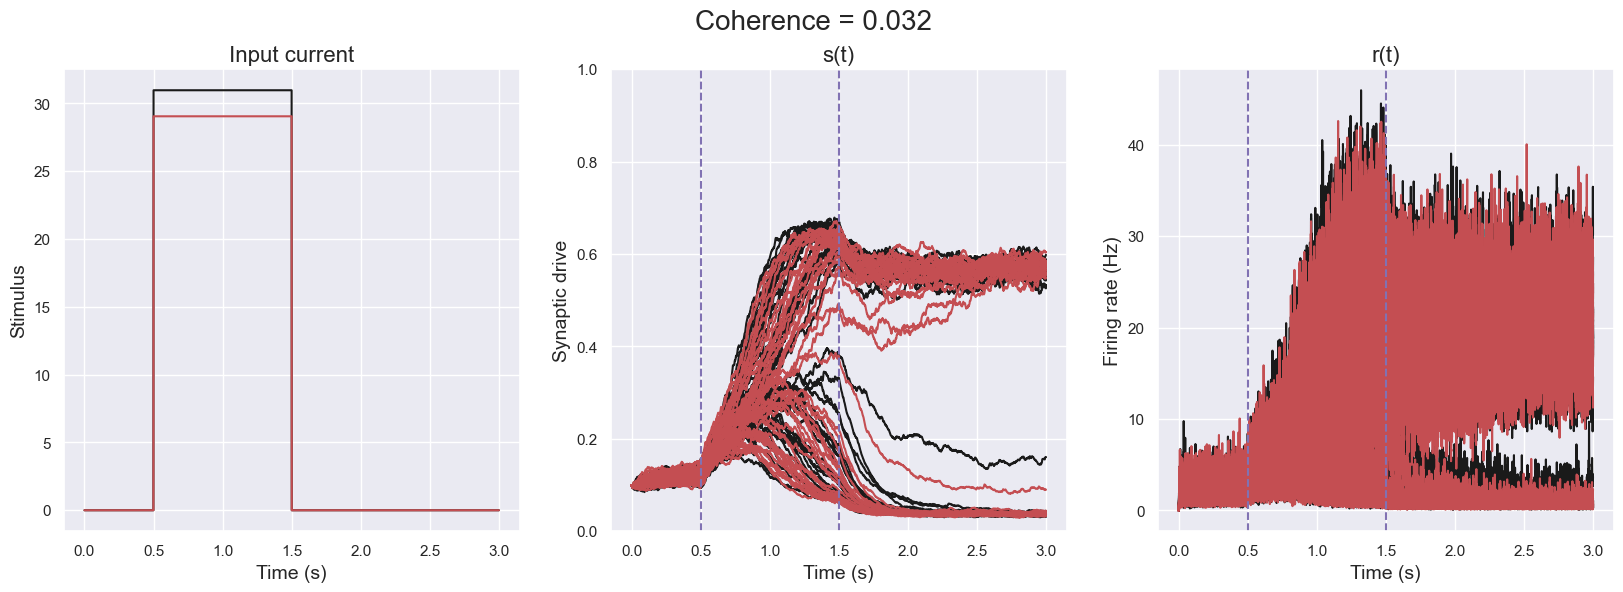

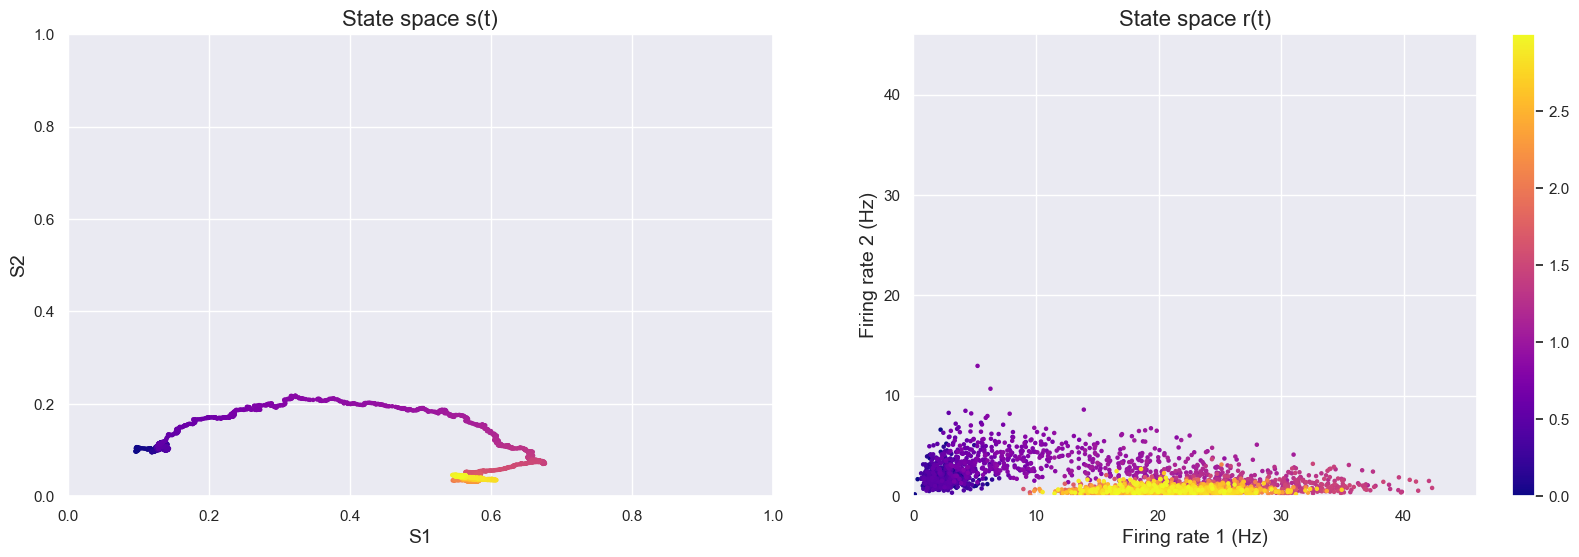

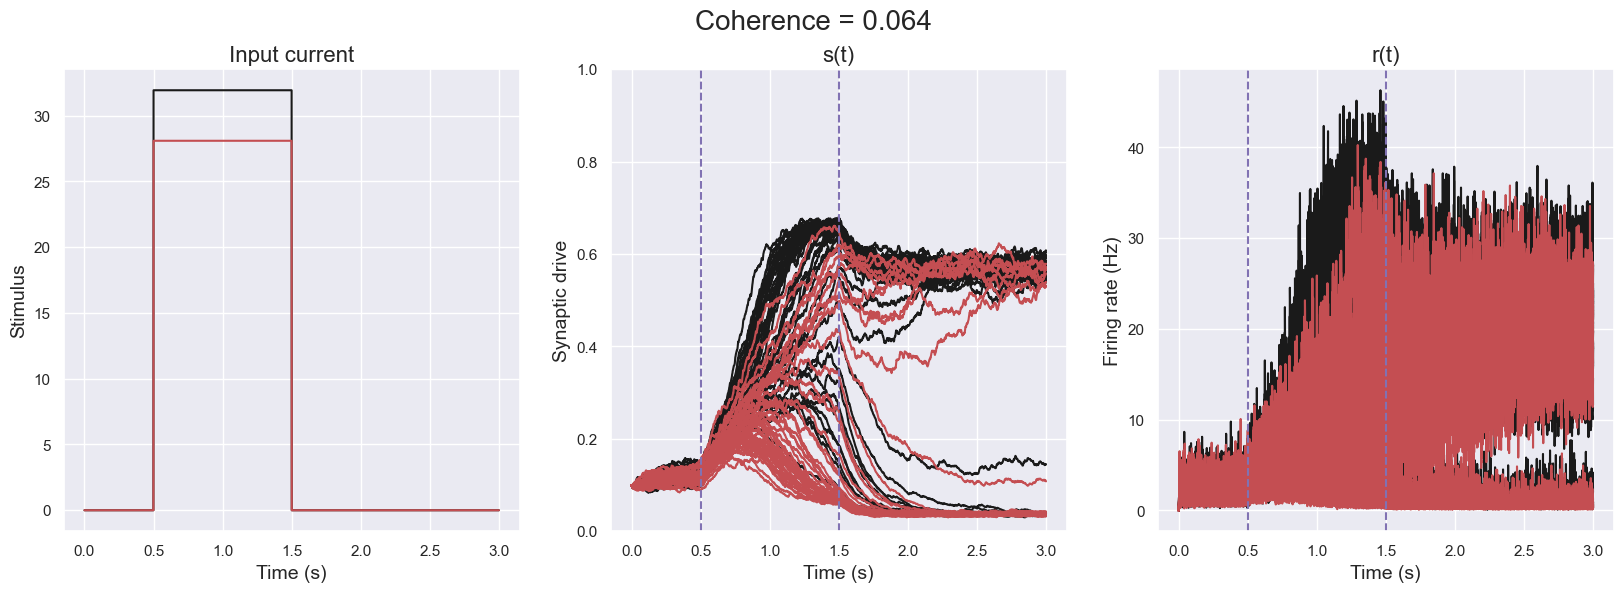

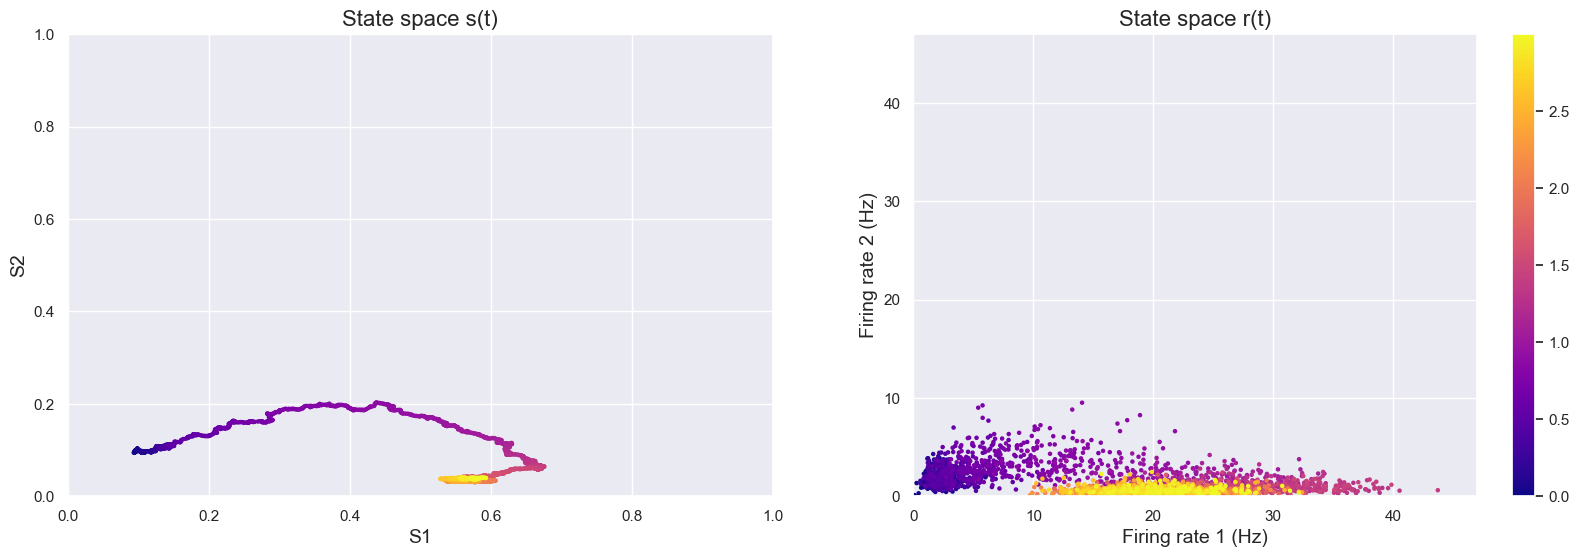

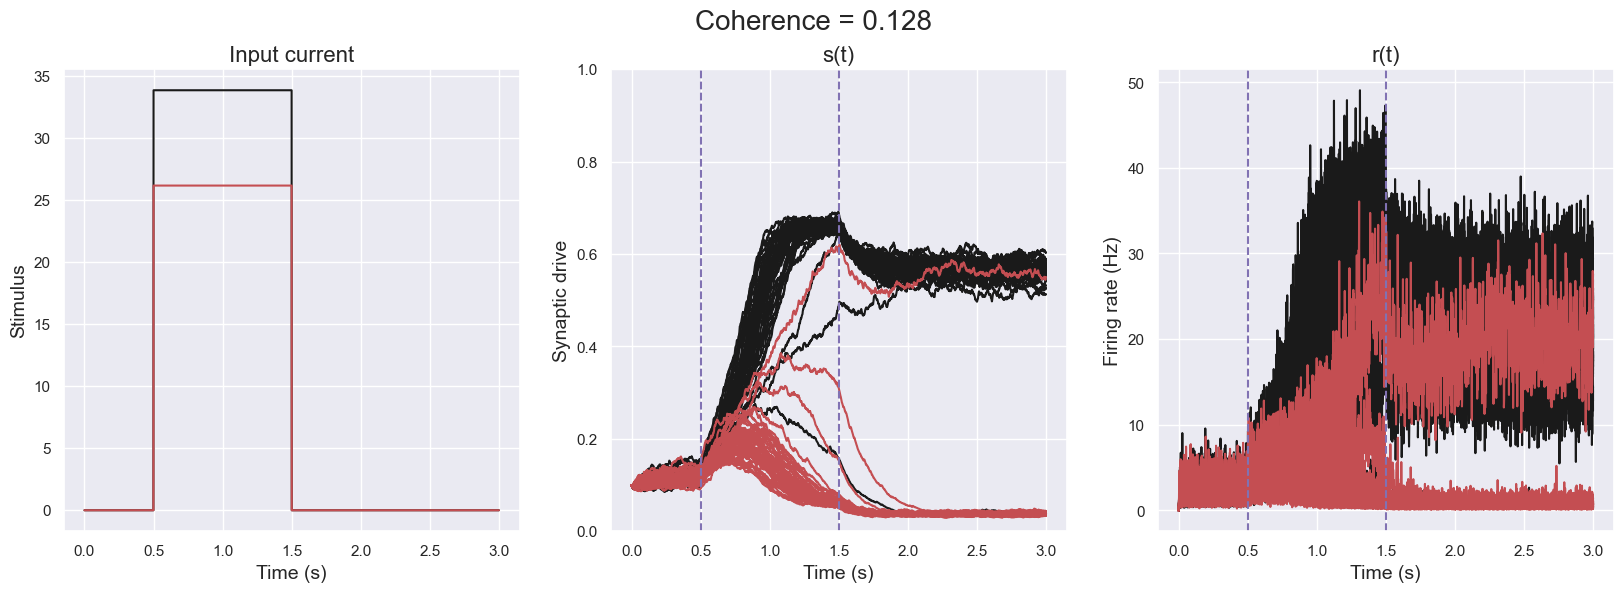

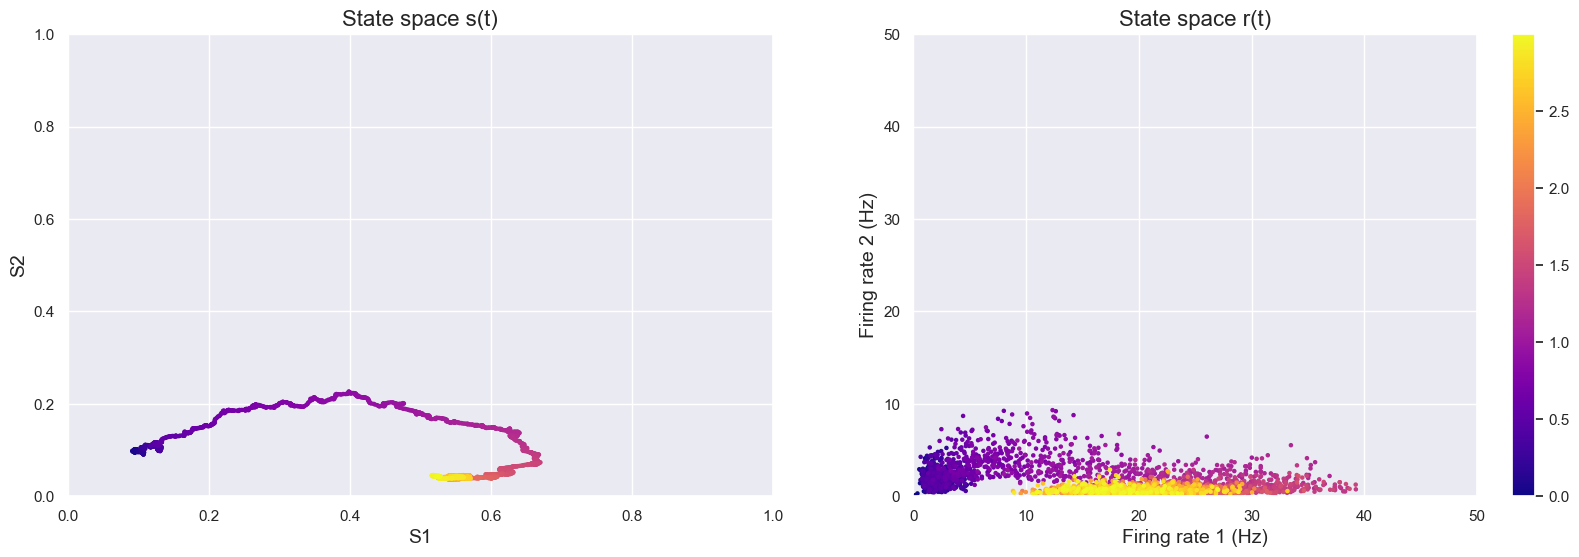

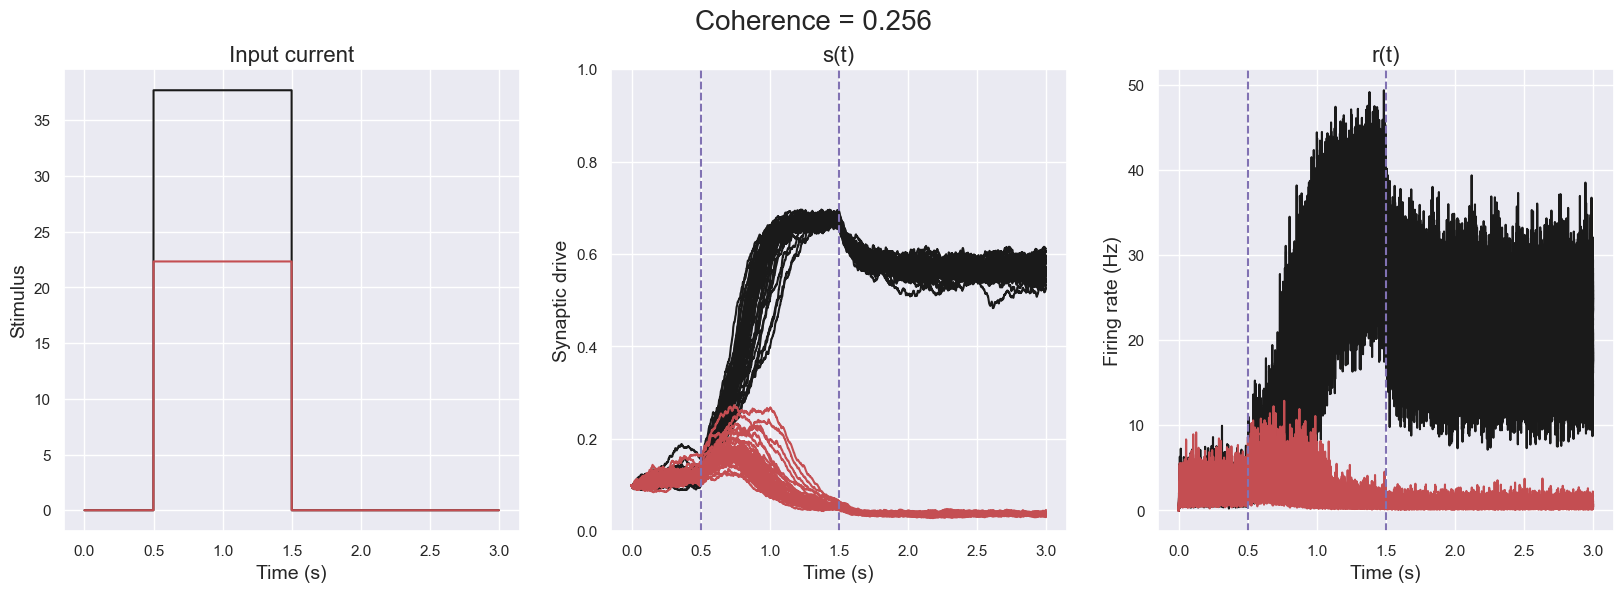

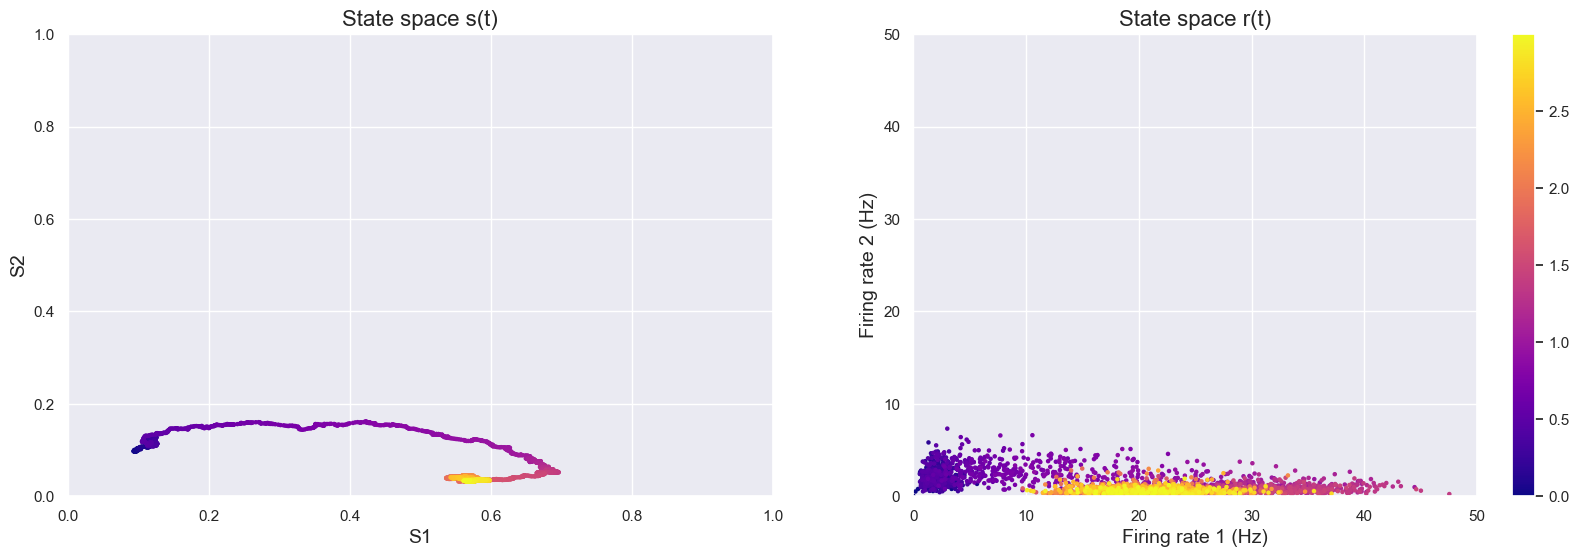

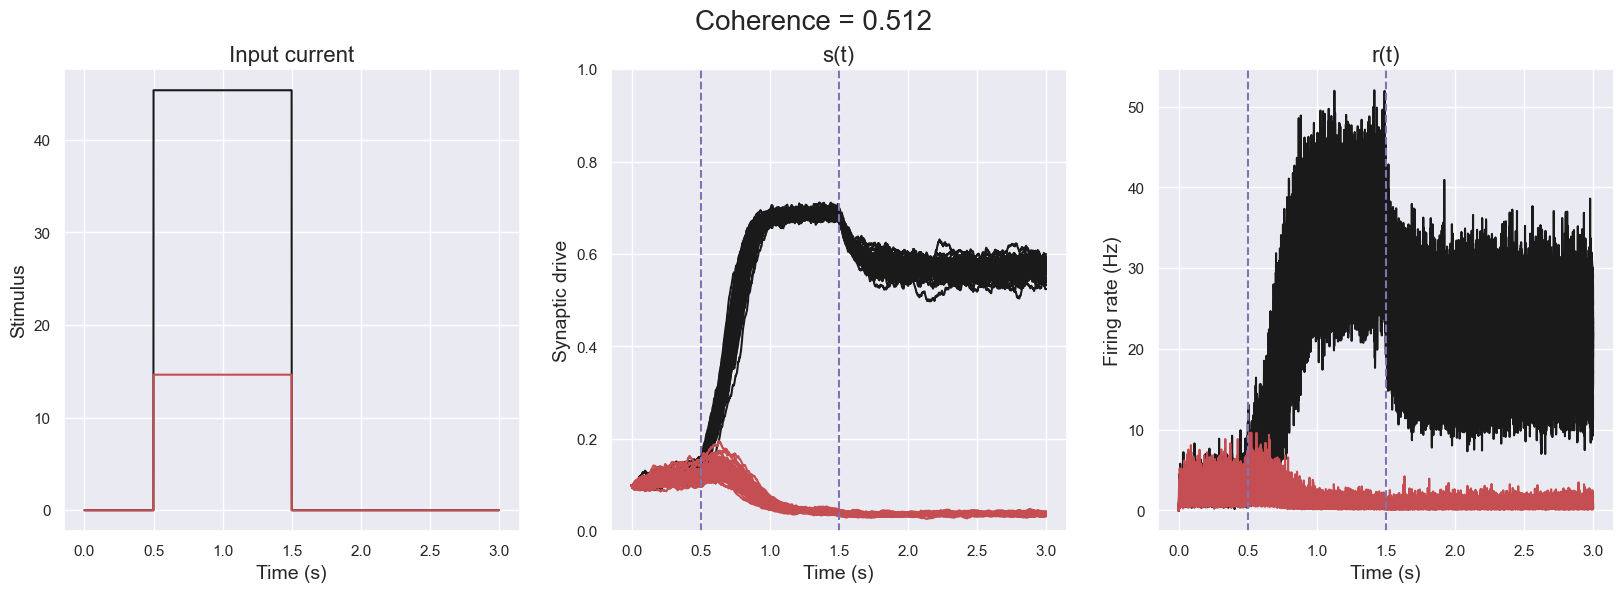

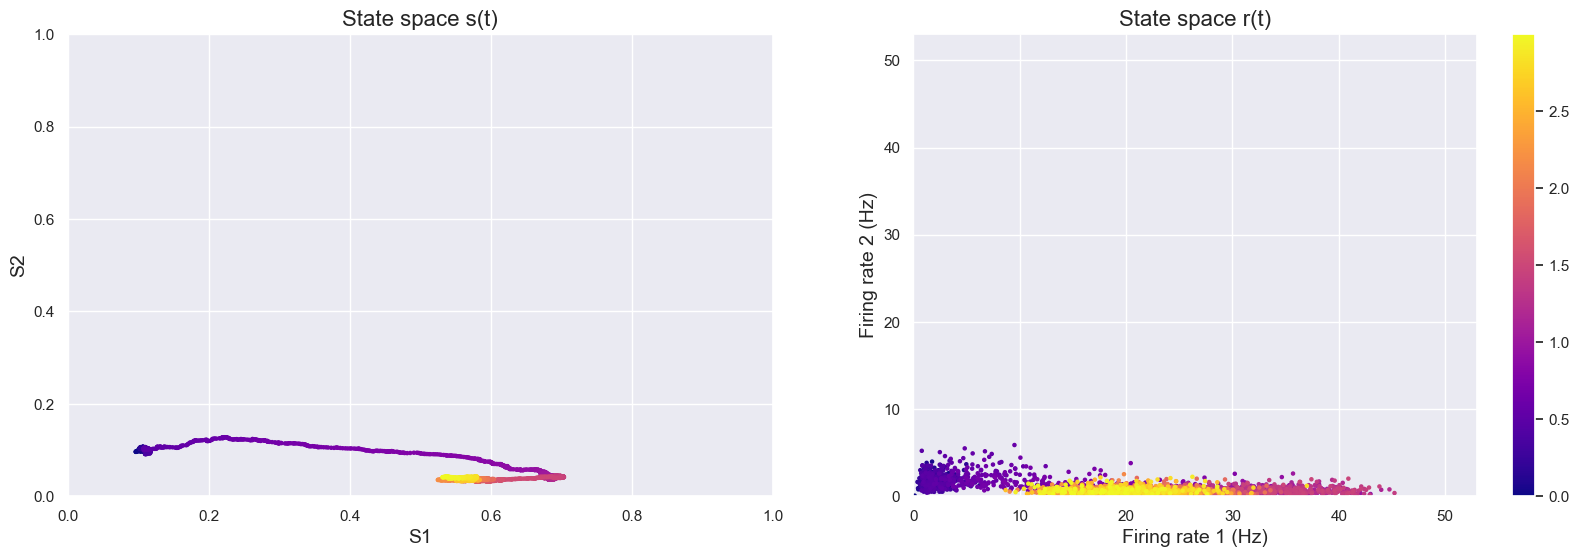

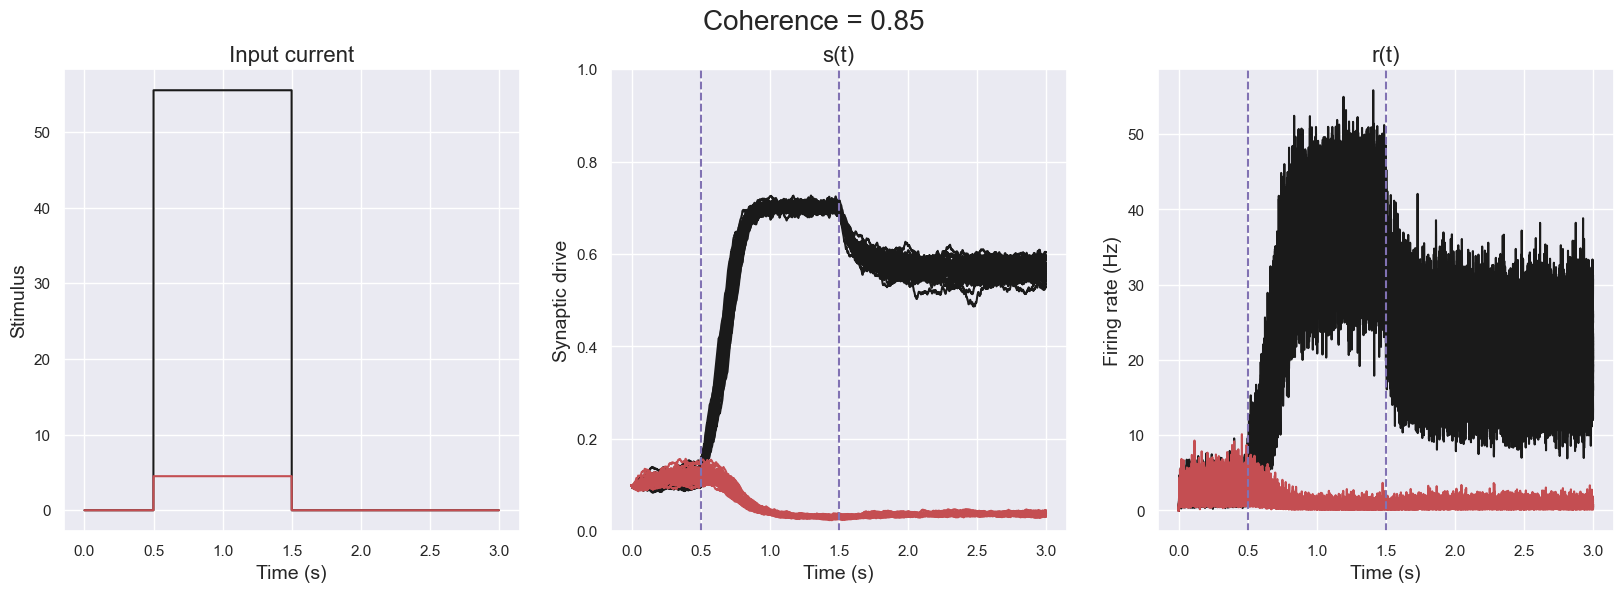

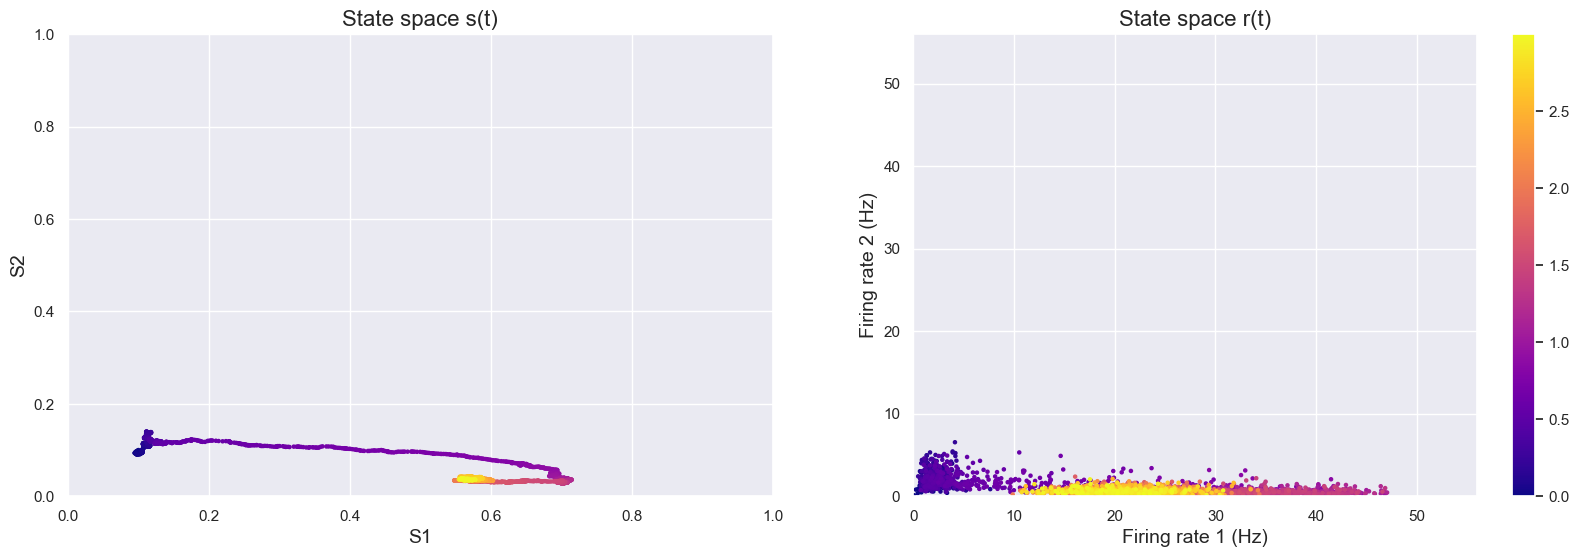

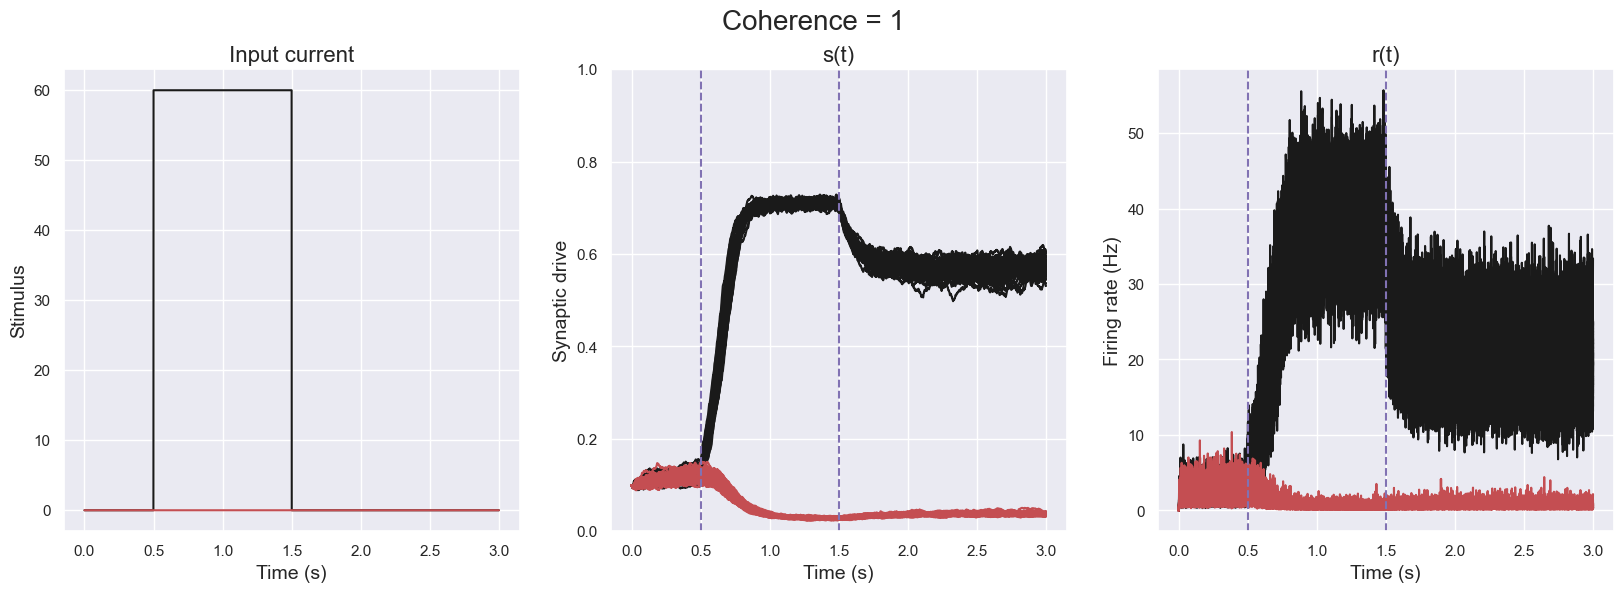

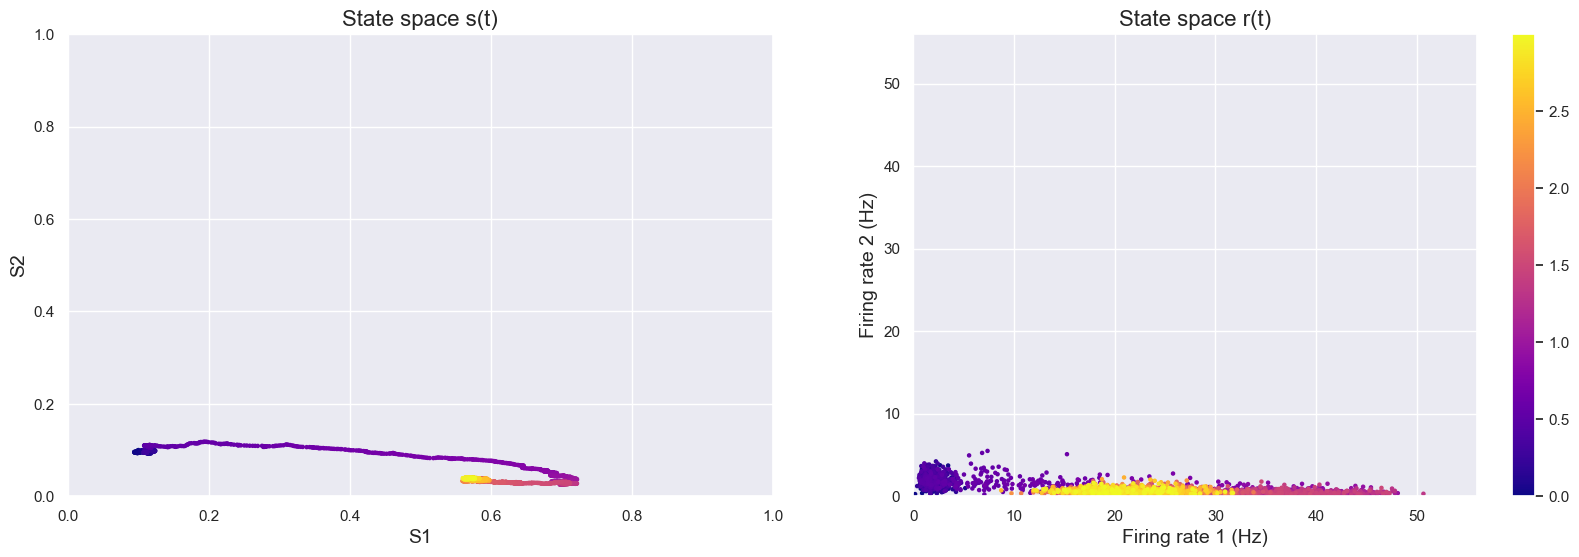

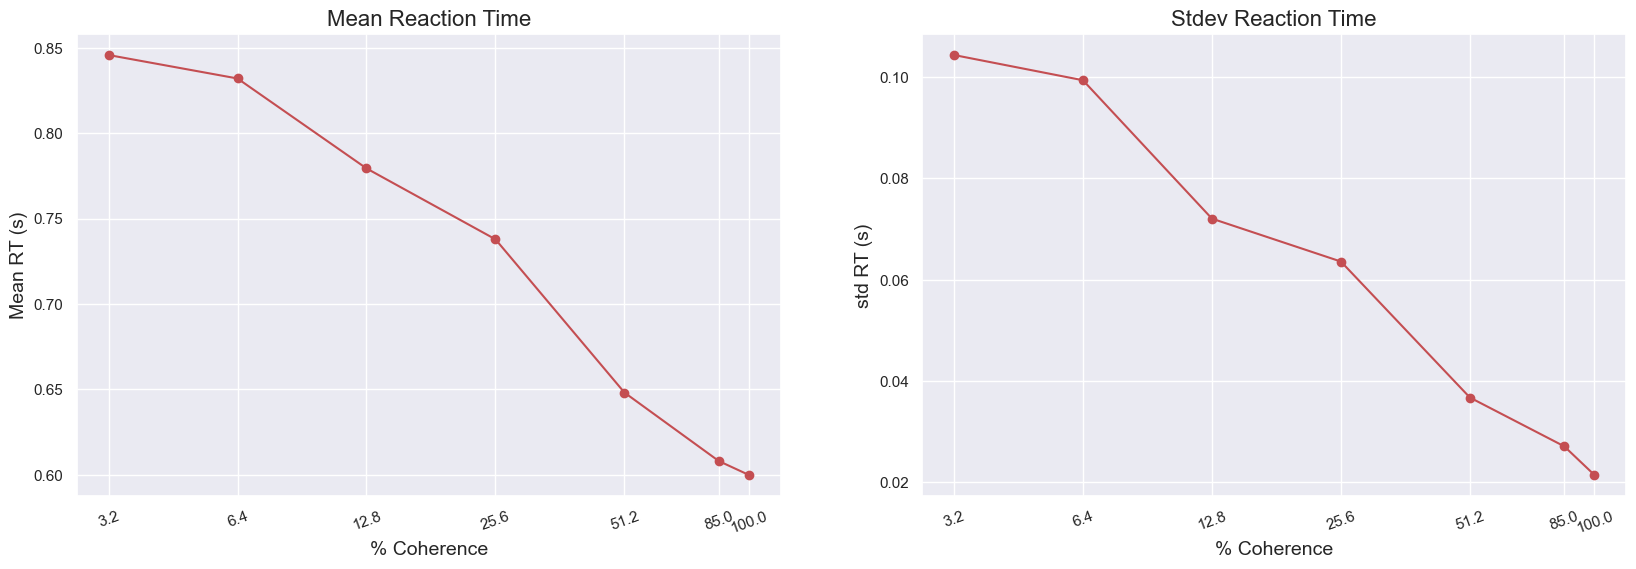

In [13]:
coherence = [0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1]
coh_100 = 100 * np.asarray(coherence)

percentage_correct = np.zeros(len(coherence),)
mu_0 = 30
f_thresh = 15

params = reset_params()
params['ntrials'] = 50
Tmax = params['Tmax']
del_t = params['del_t']
time = np.arange(0, Tmax, del_t)
RT = np.zeros((params['ntrials'],len(coherence)))

for lol in range(len(coherence)):
    c = coherence[lol]
    mu = np.zeros((2, params['len_T']))
    t_stim = [[500, 1500]]
    for tt in range(t_stim[0][0], t_stim[0][1]):
        mu[0, tt] = mu_0 * (1 + c)
        mu[1, tt] = mu_0 * (1 - c)
    s,r = synaptic_dynamics(mu, params)
    plt_str = f'3{lol}'
    plot_fr_dynamics(r, s, mu, t_stim, plt_str, params, fdict)
    choice = np.zeros((params['ntrials'],), dtype = 'int')
    for trial in range(params['ntrials']):
        thresh_idx0 = np.where(r[0,:,trial] >= f_thresh)[0]
        thresh_idx1 = np.where(r[1,:,trial] >= f_thresh)[0]
        if len(thresh_idx0) == 0:
            thresh_idx0 = [params['len_T']]
        if len(thresh_idx1) == 0:
            thresh_idx1 = [params['len_T']]
        if thresh_idx0[0] < thresh_idx1[0]:
            choice[trial] = 1
            RT[trial, lol] = thresh_idx0[0] * del_t
        elif thresh_idx0[0] > thresh_idx1[0]:
            choice[trial] = 2
            RT[trial, lol] = thresh_idx1[0] * del_t

    percentage_correct[lol] = 100 * (np.sum(choice == 1)/params['ntrials'])

fig, axs = plt.subplots(1, 2, figsize = (20, 6))
axs[0].plot(np.log(coherence), np.mean(RT, axis = 0), 'ro-')
axs[0].set_xlabel('% Coherence', fontsize = fdict['axes'])
axs[0].set_ylabel('Mean RT (s)', fontsize = fdict['axes'])
axs[0].set_title('Mean Reaction Time', fontsize = fdict['title'])
axs[0].set_xticks(ticks = np.log(coherence), labels = coh_100, rotation=20)

axs[1].plot(np.log(coherence), np.std(RT, axis = 0), 'ro-')
axs[1].set_xlabel('% Coherence', fontsize = fdict['axes'])
axs[1].set_ylabel('std RT (s)', fontsize = fdict['axes'])
axs[1].set_title('Stdev Reaction Time', fontsize = fdict['title'])
axs[1].set_xticks(ticks = np.log(coherence), labels = coh_100, rotation=20)

plt.show()


##### Varying the stimulus duration for different coherence stimuli and plotting the psychometric and chornometric curves, we can see that, increasing the stimulus duration, results in an increased accuracy for all coherence stimuli. However, we do see a pattern as a function of coherence. The accuracy is lower for low coherence stimuli and they need a higher time duration of presentation to have a decent accuracy. However, for stimuli of high coherence, even a shorter duration presentation produces a good accuracy.

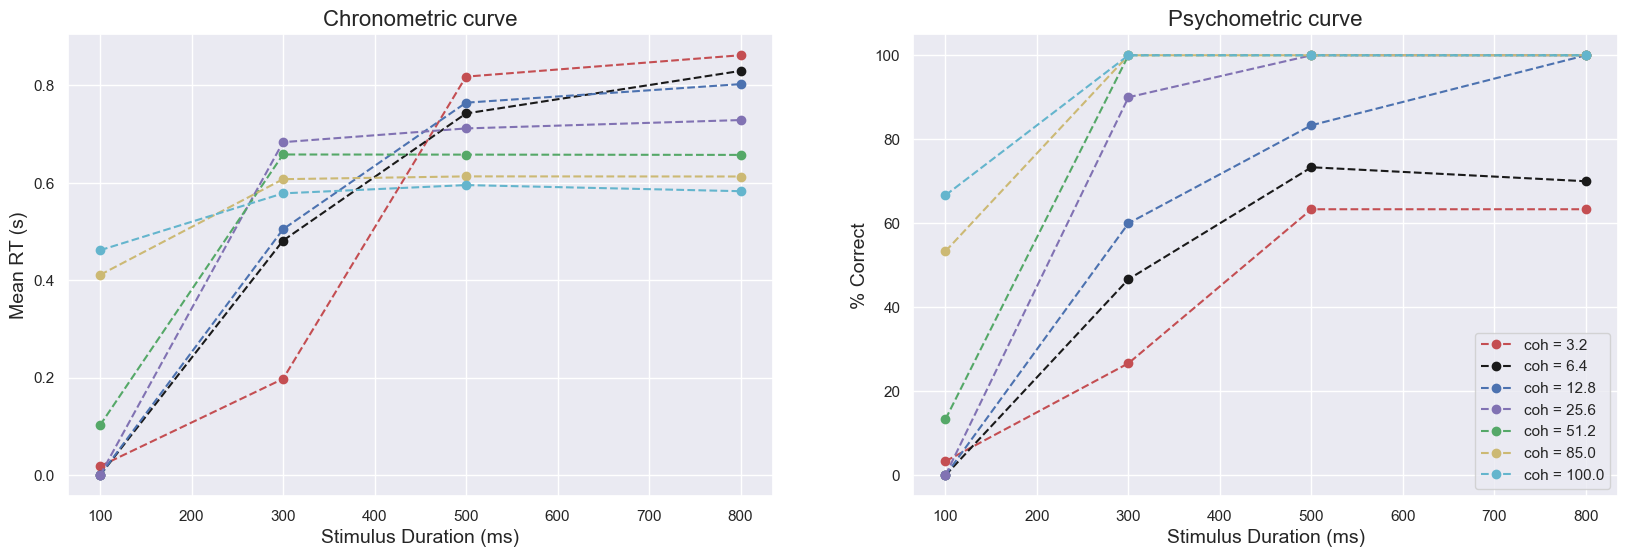

In [14]:
coherence = [0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1]
coh_100 = 100 * np.asarray(coherence)

mu_0 = 30
f_thresh = 15

params = reset_params()
params['ntrials'] = 30
Tmax = params['Tmax']
del_t = params['del_t']
time = np.arange(0, Tmax, del_t)
dur_t = [100, 300, 500, 800]
col_arr = ['r', 'k', 'b', 'm', 'g', 'y', 'c']
RT = np.zeros((params['ntrials'],len(coherence),len(dur_t)))
percentage_correct = np.zeros((len(coherence),len(dur_t)))

fig, axs = plt.subplots(1, 2, figsize = (20, 6))

for lol in range(len(coherence)):
    c = coherence[lol]
    
    for rofl in range(len(dur_t)):
        mu = np.zeros((2, params['len_T']))
        t_stim = [[500, 500 + dur_t[rofl]]]
        for tt in range(t_stim[0][0], t_stim[0][1]):
            mu[0, tt] = mu_0 * (1 + c)
            mu[1, tt] = mu_0 * (1 - c)
        s,r = synaptic_dynamics(mu, params)
        choice = np.zeros((params['ntrials'],), dtype = 'int')
        for trial in range(params['ntrials']):
            thresh_idx0 = np.where(r[0,:,trial] >= f_thresh)[0]
            thresh_idx1 = np.where(r[1,:,trial] >= f_thresh)[0]
            if len(thresh_idx0) == 0:
                thresh_idx0 = [params['len_T']]
            if len(thresh_idx1) == 0:
                thresh_idx1 = [params['len_T']]
            if thresh_idx0[0] < thresh_idx1[0]:
                choice[trial] = 1
                RT[trial, lol, rofl] = thresh_idx0[0] * del_t
            elif thresh_idx0[0] > thresh_idx1[0]:
                choice[trial] = 2
                RT[trial, lol, rofl] = thresh_idx1[0] * del_t
        percentage_correct[lol, rofl] = 100 * (np.sum(choice == 1)/params['ntrials'])

    axs[0].plot(dur_t, np.mean(RT[:,lol,:], axis = 0), col_arr[lol], linestyle = '--', marker = 'o', label = f'coh = {coh_100[lol]}')
    axs[1].plot(dur_t, percentage_correct[lol,:], col_arr[lol], linestyle = '--', marker = 'o', label = f'coh = {coh_100[lol]}')

axs[0].set_xlabel('Stimulus Duration (ms)', fontsize = fdict['axes'])
axs[0].set_ylabel('Mean RT (s)', fontsize = fdict['axes'])
axs[0].set_title('Chronometric curve', fontsize = fdict['title'])

axs[1].set_xlabel('Stimulus Duration (ms)', fontsize = fdict['axes'])
axs[1].set_ylabel('% Correct', fontsize = fdict['axes'])
axs[1].set_title('Psychometric curve', fontsize = fdict['title'])
plt.legend()
plt.show()